# Land Classificiaton Algorithms
##### An evaluation of land classification algorithms using various machine learning techniques

By Andrea Nesdoly

Student Number V00767633

April 10m 2019

Supervisor Dr. Neil Ernst

## 1. Introduction

Satellite remote sensing of the earth is an effective way to gather data over a large surface area. This data can be used for various assessments, such as determining the vegetative health of  a region, the richness of the soil, or the composition of the landscape. Land classification models discern which areas within a scene belong to which land cover type; such as, coniferous vegetation, deciduous vegetation, wetlands, water bodies, urban areas, agriculture, grasslands, or desert. This assessment can then be used for land development, natural resource management, and impact assessment studies [1]. These land classification algorithms help to turn satellite imagery into a tangible product which can then be compared to other data. As sensors become more spectrally and spatially refined, more accurate and detailed accounts for land cover are possible. Geographers are starting to take a ‘hands off’ approach in their analyses, and trust in computing power to derive their products. Machine learning and artificial intelligence is emerging as a large player in perfecting models for geography analyses. 

This study will perform a pixel based comparison between maximum likelihood estimation (MLE), support vector machine (SVM), and neural network (NN) land classification models. Each machine learning algorithm (MLA) will also be compared to the a MLE classification model created with a known software in the industry for validity. Furthermore, it is assumed that the intended audience has a general understanding or knowledge of geographical and remote sensing terms and processes. As there are many avenues which have been explored in previous studies, with a large variety of MLA's to compare, this project will determine if the same results are replicable with these three MLAs.

In [1]:
# Bring in required libraries
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

import time
import warnings

# Import machine learning algorithms
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Import statistical libraries
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_validate, cross_val_score, ShuffleSplit, StratifiedKFold
from statsmodels.stats.contingency_tables import mcnemar
from skll import kappa

# Ignore warning which come from cross validation, and precision, recall, f-measure functions
# The warnings appear when there are a lack of samples within a class, or a missing class
# All warnings were checked before this was called
warnings.filterwarnings('ignore')

## 2. Data and Methods

### 2.1 Study Area 

The study area is the southern tip of Vancouver Island which includes the city of Victoria and the Saanich Peninsula (Fig. 1). It was chosen because it has a complex heterogenous landscape and very little snow cover. It contains various agriculture, urban, and water based landscapes which lends to a more difficult and interesting classification. The study area was chosen due to availability of personal knowledge of the landscape to collect a sample set. Seven land classes were chosen based on a similar study in the Lower Mainland of British Columbia [2]. As the likelihood of snow or ice in the mild Vancouver Island climate is quite low, instead of including this land cover class, this study will separate the forest and shrub classes (Table 1).

Table 1: Land Cover Classes

|Land Class     |ID|
|---------------|--|
|Urban or Barren|1 | 
|Forest         |2 |
|Shrub          |3 |
|Agriculture    |4 |
|Grassland      |5 |
|Wetland        |6 |
|Water          |7 |


### 2.2 Data

Remote sensing data was made courtesy of the European Space Agency (ESA) and was collected using the Sentinel 2A mission on September 28, 2018 [3]. ESA is at the forefront of the open source data trend as all the data collect from the satellite missions it conducts are available to the general public. This is done to foster the growth of knowledge and pursuit of scientific discovery. ESA is known for delivering quality products at high spatial and temporal resolution with various sensors and satellite missions including: Sentinel 1, Sentinel 2A and Sentinel 2B. Sentinel 2A is an passive multi-spectral sensor designed for data collection over a terrestrial landscape, so it has varying spatial resolutions of either 10 metres, 20 metres, or 60 metres depending on which spectral band is being considered (Table 2)[4]. Sentinel 2A data was considered due to the open source initiative and high spatial resolution which lends to more detailed land classifications. 

Specifically the remote sensing image tile attained has a central latitude and longitude 48°15’27.01”N and 123°36’29.39”W respectively. As this is a passive sensor it requires the reflection of sunlight off the earths surface, so cloud cover, or water vapor, will absorb, scatter, or block the optical signal; therefore, the data acquired on September 28, 2018 was chosen due to its clarity. Furthermore, data attained during this season will have more variety of vegetation when compared to the winter season. 

Table 2: Sentinel 2A Spectral Bands and Resolution where NIR is near infrared, MIR is mid infrared, VNIR is vegetation near infrared (red edge spectral domain), and SWIR is short wave infrared [4].

|Band Number|Type  |Central Wavelength (nm)|Bandwidth (nm)|Resolution (m)|
|-----------|------|-----------------------|--------------|--------------|
|   1       |Violet| 442.7                 | 27           | 60           |
|   2       |Blue  | 492.4                 | 98           | 10           |
|   3       |Green | 599.8                 | 45           | 10           |
|   4       |Red   | 664.6                 | 38           | 10           |
|   5       |VNIR  | 704.5                 | 19           | 20           |
|   6       |VNIR  | 740.5                 | 18           | 20           |
|   7       |VNIR  | 782.8                 | 28           | 20           |
|   8       |NIR   | 832.8                 | 145          | 10           |
|   8a      |VNIR  | 864.7                 | 33           | 20           |
|   9       |MIR   | 945.1                 | 26           | 60           |
|   10      |MIR   | 1373.5                | 75           | 60           |
|   11      |SWIR  | 1613.7                | 143          | 20           |
|   12      |SWIR  | 2202.4                | 242          | 20           |

#### Software and Libraries
This project was scripted with Python and its various libraries including: scikit-learn for machine learning functions, osgeo-gdal for GeoTiff and raster manipulation, numpy and matplotlib for data manipulation and visualization, and statsmodel and skll for statistical analysis [5]. For a comparison against known geographic software a highly regarded software for remote sensing projects was used: PCI Geomatica [6]. It is a paid product provided by the UVic Geography Department. PCI Geomatica was not well suited for manipulating the Sentinel 2A product, so ESA SNAP software was required for preprocessing [7]. 

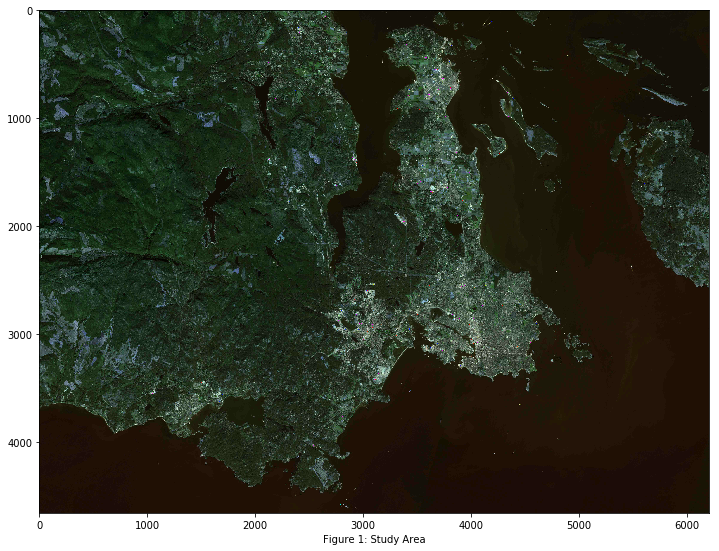

In [2]:
#load and display the data

# Set paths to GeoTiff and figures
tif_path = 'C:\\Users\\andre\\Documents\\UVIC\\ResearchProject\\Working\\S2A_0928\\'

# Open GeoTiff file
dataset = gdal.Open(tif_path+'S2A_0928_MLE_whole.tif', gdal.GA_ReadOnly)

# Display RGB image with bands 4,3,2 respectively
options_list = ['-ot Byte','-of JPEG', '-b 2', '-b 3', '-b 4', '-scale_2', '-scale_3','-scale_4' ] 
options_string = " ".join(options_list)

gdal.Translate(tif_path+'study_area.jpg', tif_path+'S2A_0928_MLE_whole.tif', options=options_string)
img = plt.imread(tif_path+'study_area.jpg')

plt.figure(1,figsize=(12,12))
plt.xlabel('Figure 1: Study Area')
plt.imshow(img*4) #Brighten image with scalar multiplication

In [3]:
# Save each band from dataset in a 3D array
S2_array = np.zeros((1,1,1))
#print('Descriptive statistics for each band')
stats_all = np.empty([4])
for x in range(1, dataset.RasterCount + 1):
    band = dataset.GetRasterBand(x)
    array = band.ReadAsArray()
    if x <= 1:
        S2_array = np.array(array)
    else:
        S2_array = np.dstack((S2_array, np.array(array)))
   
    # Save statistics for each band
    stats = band.GetStatistics(True,True)
    stats_all = np.vstack((stats_all,stats))
    
data_bands = dataset.RasterCount
num_bands = data_bands - 2
print('Shape of Dataset')
print(S2_array.shape)
print('Number of bands')
print(data_bands)

Shape of Dataset
(4657, 6205, 13)
Number of bands
13


#### 2.2.1 Data Preprocessing
The remote sensing product was delivered by ESA as a level 1C product which is top of the atmosphere spectral returns meaning that the atmospheric effects persist within the dataset. Therefore, the data required preprocessing using an atmospheric correction algorithm to return the bottom of the atmosphere spectral returns. An atmospheric correction eliminates aerosol and cloud effects and accounts for adjacency effects from contiguous pixels. Typically, the data product contains metadata and atmospheric data required for this correction, and there are many software packages which could be used. PCI Geomatica contains an atmospheric correction called ATCOR which is well known to work with other sensors, unfortunately it could not pull the metadata required from the Sentinel 2A package; therefore, ESA's SNAP software was used to correct atmospheric effects. The Sen2Cor atmospheric correction, provided by ESA, takes information from the metadata and internal look up tables. It considers known information about aerosol type, aerosol optical thickness, ozone content, and water vapor over the given location to correct for atmosphere. The haze and cirrus cloud removal were also performed to ensure  utmost clarity of the scene.

The original remote sending tile was subset to the study area which consists of the Saanich Peninsula and forested regions to the west, and is ~2890 km<sup>2</sup> (Fig.1). A spectral subset was also done to remove bands 11 and 12 from the final product because they are the most responsive to atmospheric effects and used to perform atmospheric correction, but are less determinant in land cover [4]. While subsetting the data, spatially and spectrally, all bands were resampled to a 10m spatial resolution using bilinear resampling. The spectral returns for the bands which are 20m and 60m resolution are less influential than the 10m bands for this study because bands 2, 3, 4 and 8 are in the optical part of the electromagnetic spectrum (Fig.2). This portion of the electromagnetic spectrum interact greatly with terrestrial features. For example, vegetation interacts heavily with the green, red, and near-infrared parts of the spectrum and water does not interact well with any part of the spectrum.

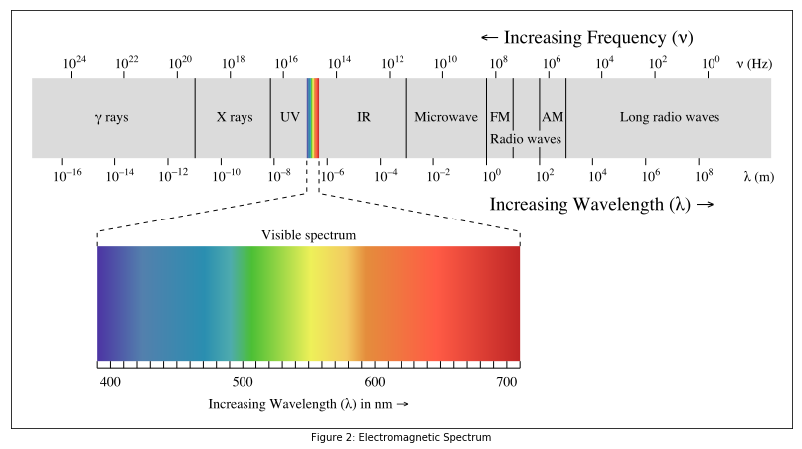

In [4]:
img_spec = plt.imread(tif_path+'EM_spectrum.png')
plt.figure(2, figsize=(14,10))
plt.xlabel('Figure 2: Electromagnetic Spectrum')
plt.xticks([])
plt.yticks([])
plt.imshow(img_spec)

#### 2.2.2 Training Sample Selection

Using visual confirmation from Google Earth, and personal knowledge of the study area, homogenous samples were taken for each class. In some cases finding homogenous samples was difficult which led to an imbalance in the number of pixels collected for each class (Fig.3). In the case of water there are many water bodies clearly visible throughout the scene which are obviously homogenous, so larger sample polygons where created. In the case of grassland, shrub, and wetland there were no large homogenous samples which lead to a smaller number of pixels chosen. 

The training data include 7 classes: [1 2 3 4 5 6 7]
Class ID 1: Urban
Class ID 2: Forest
Class ID 3: Shrub
Class ID 4: Agriculture
Class ID 5: Grassland
Class ID 6: Wetland
Class ID 7: Water


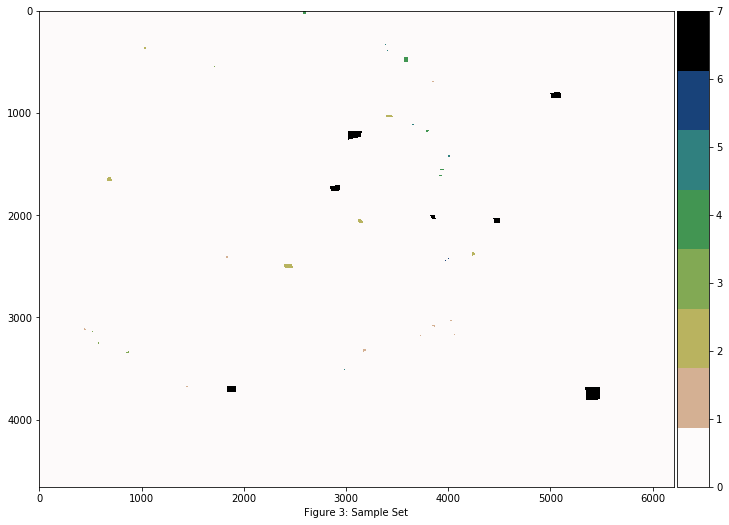

In [5]:
# Extract classification labels from dataset
#!!!CHANGE COLOURS AND SIZE
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
sites = S2_array[:,:,11]
S2_image = S2_array[:,:,0:11]
MLE_image = S2_array[:,:,12]
l,w = sites.shape
labels_ID,counts = np.unique(sites[sites>0], return_counts = True)
print('The training data include %d classes: %s'%(labels_ID.size, labels_ID))

# Create dictionary for each class
class_labels = {1:'Urban',2:'Forest',3:'Shrub',4:'Agriculture',5:'Grassland',6:'Wetland',7:'Water'}
for i in labels_ID:
    print('Class ID %d: %s'%(i,class_labels[i]))

# Display training sites
plt.figure(3,figsize=(12,12))
plt.xlabel('Figure 3: Sample Set')
im_sites = plt.imshow(sites, cmap=plt.cm.get_cmap('gist_earth_r', 8))
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_sites, cax=cax)

In [6]:
# Prepare sample table
samples = S2_array[:,:,:12]
samples = samples.reshape(l*w,12)
sample_table = samples[samples[:,-1]>0]
ls,ws = sample_table.shape

print('The number of training pixels are: %d'%(ls))
print('The total number of pixels is: %d'%(l*w))
print('The number of urban pixels is: %d'%(counts[0]))
print('The number of forest pixels is: %d'%(counts[1]))
print('The number of shrub pixels is: %d'%(counts[2]))
print('The number of agriculture pixels is: %d'%(counts[3]))
print('The number of grassland pixels is: %d'%(counts[4]))
print('The number of wetland pixels is: %d'%(counts[5]))
print('The number of water pixels is: %d'%(counts[6]))

The number of training pixels are: 63281
The total number of pixels is: 28896685
The number of urban pixels is: 2758
The number of forest pixels is: 9015
The number of shrub pixels is: 676
The number of agriculture pixels is: 3003
The number of grassland pixels is: 1303
The number of wetland pixels is: 298
The number of water pixels is: 46228


Each land classification type has a unique spectral signature which allows the algorithm to determine which class it belongs to (Fig. 4). These spectral signatures need to be separable in order to classify well. There are two statistical measures of separability which were considered when choosing sample data. They are the Bhattacharyya distance and the transform divergence measures of signature separability where values greater than 1.8 are considered good separability and a value of 2.0 is perfect separability. These values can be read along the diagonal of the matrix. Bhattacharyya distance is a popular measure of separability and takes into consideration the sample mean and sample covariance matrix between two classes [8]. It is calculated with the following formula:

$$BD = \frac{1}{8} (M_{2}-M_{1})^T \Big(\frac{C_{1}+C_{2}}{2}^{-1}\Big) (M_{2}-M_{1})+ \frac{1}{2} ln \Big( \frac{|\frac{C_{1}+C_{2}}{2}|}{\sqrt{|C_{1}||C_{2}|}}\Big)$$

where $BD$ is the measure of separability, $M$ is the sample mean for sample 1 or 2, and $C$ is the sample covariance matrix for sample 1 or 2. This calculation is repeated for each class comparison which results in a matrix of separability values. 

Transformed divergence also considers the mean and covariance matrix to calculate a measure of separability in a slightly different fashion [9]. It is calculated, using the same variables,  with the following formula:

$$TD = 2000 \bigg(1-\exp{\Big(\frac{-D_{12}}{8}\Big)}\bigg)$$

where,

$$D_{12} = \frac{1}2{} tr \Big((C_{1}-C_{2})(C_{1}-C_{2})\Big) + \frac{1}{2}\Big((C_{1}^{-1} - C_{2}^{-1})(M_{1}-M_{2})(M_{1}-M_{2})^{T}\Big) $$

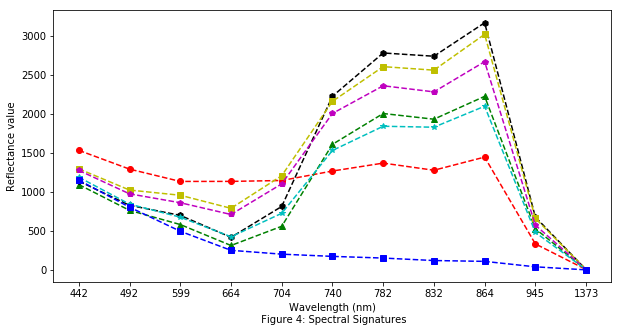

In [47]:
# Extract and display spectral signatures for the 7 classes
#spec_table2 = spec_table[0,:11,1:].T
#labels = spec_table[-1,1:].T
idx = sample_table

idx1 = np.average(idx[idx[:,-1]==1],axis=0)
idx2 = np.average(idx[idx[:,-1]==2],axis=0)
idx3 = np.average(idx[idx[:,-1]==3],axis=0)
idx4 = np.average(idx[idx[:,-1]==4],axis=0)
idx5 = np.average(idx[idx[:,-1]==5],axis=0)
idx6 = np.average(idx[idx[:,-1]==6],axis=0)
idx7 = np.average(idx[idx[:,-1]==7],axis=0)

bandnm = [442,492,599,664,704,740,782,832,864,945,1373]

plt.figure(4,figsize=(10,5))
plt.plot(idx1[:-1], '--ro', idx2[:-1], '--g^', idx3[:-1], '--kh', idx4[:-1], '--ys',
         idx5[:-1], '--mp', idx6[:-1], '--c*', idx7[:-1], '--bs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10],[442,492,599,664,704,740,782,832,864,945,1373])
plt.xlabel('Wavelength (nm)\n Figure 4: Spectral Signatures')
plt.ylabel('Reflectance value')
plt.show()

#### 2.2.3 Data Processing
Once the training samples were found (using PCI Geomatica) a new band representing the land classification value associated with that pixel was added to the GeoTiff. This GeoTiff was converted into a 3D numpy array, and the sample pixels were extracted along with the reflectance value from each spectral band which matched the pixel's location. This was then converted to a 2D numpy array to represent a data table that could be separated into a training and testing sample set. 70% of the sample data was used train each classifier and 30% was used to test each classifier [10]. Then the 10m resolution study area image was segmented into four sections in order to run the prediction functions more efficiently as it is 28,896,685 pixels by 11 bands. If this was not done, some algorithms had issues with depleted memory, and results required hours/days of time.

In [8]:
# Extract Y_train and X_train from table
ln, wd = sample_table.shape
X = sample_table[:,0:wd-1]
Y = sample_table[:,-1]

X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.30)

print('Testing and training set shape:')
print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)
print(Y_train.shape)

print('Image to be classified shape:')
image_class = S2_image.reshape(l*w,num_bands)
print(image_class.shape)

# Divide data into to 4 for faster processing
datLen,fields = image_class.shape 
qt = int(datLen/4)
image_classAa = image_class[:qt,:]
image_classAb = image_class[qt:qt*2,:]
image_classBa = image_class[qt*2:qt*3,:]
image_classBb = image_class[qt*3:,:]

Testing and training set shape:
(18985, 11)
(44296, 11)
(18985,)
(44296,)
Image to be classified shape:
(28896685, 11)


### 2.2 Classification Methods
#### 2.2.1 PCI Geomatics base classification model
PCI Geomatica is a known remote sensing software with a variety of land classification algorithms available. The maximum likelihood classification model used is breifly described in PCI Geomatic's help section. It assumes a Gaussian probablity distribution for all feature classes, and uses the Mahalanobis minimum distance classifier before calculating the "a posteriori" with Bayes Rule [11]. 

After the samples were selected confirmation of spectral signature separability was done and the classification algorithm performed. When the classification model was complete an accuracy assessment was conducted by selecting 40 pixels at random and visually confirming if they were classified correctly by the user. Once this was complete a confusion matrix, accuracy score, average accuracy score, and kappa coefficient were output using software tools. The classification model itself is output to a band within the dataset, so all the pixels align, are easily convertible, and can be extracted.

In [49]:
# Load data required for accuracy assessment and visualization
# All statistcs come from the classification report output by PCI software
bhat_dist = plt.imread(tif_path+'sig_sep_bhat.jpg')
trans_dive = plt.imread(tif_path+'sig_sep_trans.jpg')

# Accuracy scores and Confusion matrix
pci_score = 0.9932
pci_score_avg = 0.9738 
pci_con_mx = np.array([[3,0,0,1,0,0,1],[0,9,1,0,0,0,0],[0,3,2,0,0,0,0],[1,0,0,1,1,0,0],
                       [0,0,0,0,0,0,0],[0,1,1,0,0,0,0],[0,0,0,0,0,0,15]])
pci_kappa = 0.98468  

# Calculate the percent coverage for each class
pci_cl,pci_cnt = np.unique(MLE_image, return_counts = True)
pci_perc_cov = pci_cnt/(l*w)

#### 2.2.2 Maximum Likelihood Classification
Maximum likelihood estimation (MLE) is one of the most common classification algorithms in remote sensing [12]. It is a probabilistic model based on Bayes theorem which predicts the probability of each pixel's class by choosing the classification with the highest likelihood. The Gaussian probability distribution was assumed for this dataset after analyzing the histogram of each sample class. The major inputs for this probability distribution are the class mean and covariance matrix which are estimated from the sample data with the assumption that it is independent and identically distributed [13]. The Gaussian probability model follows:

$$ P(x_{i}|y) = \frac{1}{\sqrt{2\pi C_{y}^{2}}}\exp\Big(-\frac{(x_{i}-M_{y})^{2}}{2C_{y}^{2}}\Big) $$

where $x$ are the data, $y$ are the labels, $M$ is the class mean, and $C$ is the covariance matrix [5]. This algorithm differs slightly from the PCI MLE process which should be considered in the results [11].

The complexity of each MLA is difficult to determine as it depends on the data properties and parameters of the algorithm. Therefore, the basic complexity will be considered, where for $n$ number of training samples and $p$ number of features, training the data is $O(np)$ and predicting the data is $O(p)$ [14].

In [10]:
# Maximum Likelihood Classifier
mle_start = time.time()

mle = GaussianNB()

# Fit the classifier on the training dataset
mle.fit(X_train, Y_train)

mle_fit_t = time.time()

# Predict the classification for each pixel in image
mle_Y_predAa = mle.predict(image_classAa)
mle_Y_predAb = mle.predict(image_classAb)
mle_Y_predBa = mle.predict(image_classBa)
mle_Y_predBb = mle.predict(image_classBb)

mle_pred_t = time.time()

# Reshape to display image
mle_Y_whole = np.append(mle_Y_predAa,mle_Y_predAb)
mle_Y_whole = np.append(mle_Y_whole,mle_Y_predBa)
mle_Y_whole = np.append(mle_Y_whole,mle_Y_predBb)
mle_img = mle_Y_whole.reshape(l,w)

# Accuracy score using the test set data
mle_score = mle.score(X_test,Y_test)

# Calculate the percent coverage for each class
mle_cl,mle_cnt = np.unique(mle_img, return_counts = True)
mle_perc_cov = mle_cnt/(l*w)

In [11]:
# Calculate time efficiency for MLE
print('The time it took to fit the classification model with the training data: %.6f seconds'%(mle_fit_t-mle_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(mle_pred_t-mle_fit_t))
print('The time it took to run the classification method: %.6f seconds'%(mle_pred_t-mle_start))
print('The number of classes in this image: %s'%(np.unique(mle_Y_whole)))

The time it took to fit the classification model with the training data: 0.015631 seconds
The time it took to predict the image classification matrix: 38.999887 seconds
The time it took to run the classification method: 39.015518 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


#### 2.2.3 Support Vector Machine
Support vector machine is a non-parametric algorithm which builds a hyperplane in the maximum gap within the training sample and classifies the segments into one of the possible classes [15]. To map non-linear decision boundaries into linear ones in a higher dimension, the four most frequently used types of kernel functions in SVM algorithms are linear, polynomial, radial basis function (RBF), and sigmoid kernels [5]. Important parameters for SVM classifiers are the regularization and gamma parameter. The regularization parameter, or cost, prevents overfitting, and gamma changes the shape of the separating hyperplane [15]. For this reason SVM is effective in high dimensional spaces, and the parameters chosen influence overall accuracy [16]. Typically parameter setting is difficult for users and require an exhaustive trial and error search [15,17]. 

As most literature uses RBF kernel it was considered in this study, but was found to take an excessive amount of time to train and predict such a large dataset alongside the difficulties of finding the correct parameters. Furthermore, there is no magic formula for choosing the cost and gamma parameters for the RBF kernel, in some literature they use very large gamma of 200-20000 [17] and other literature use very small gamma of 0.0000001-0.0001 [15]. After attempting a variety of cost and gamma values with little improvement beyond a 0.73 accuracy score, and an inability to encompass all feature classes, it was determined that the linear and polynomial kernels would take precedence. Furthermore, these kernels have not been extensively analyzed.

A variety of regularization and gamma parameters were considered for the linear and polynomial kernels. It was found that the value of the parameters did not greatly affect the accuracy score for the linear kernel; in fact, only the regularization parameter had any effect on the accuracy score. Therefore, the regularization and gamma parameters chosen were the default parameters of 1.0 and $1/n$ respectively, where $n$ is the number of features [5]. Polynomial kernels with degree 2 through 5 were tested with a range of regularization and gamma values. The final degree, regularization, and gamma parameters chosen were 3 degrees, 1.0, and $1/n$. 

As the number of training vectors increases so does the SVM complexity. Although most SVM kernels can be evaluated in $O(p)$ time and solving the quadratic programming problem has a complexity of $O(n^3)$. The quadratic programming problem separates support vectors from training vectors. Typically training the data is $O(n^2p+n^3)$ and predication is $O(n_{sv}p)$ where $n_{sv}$ is the number of support vectors. The scikit-learn SVM library scales this to $O(n^2p)$ and $O(n^3p)$ [5].

In [12]:
# Try different C and gamma for linear kernel
C_try = [0.01,0.1,0.3,0.8,1,3,10]
gamma_try = [0.01,0.1,0.5,1,1.5,5,10]
#degree_try = [2,3,4,5]
test_acc_lin = np.zeros([49,3])
test_acc_poly = np.zeros([49,3])
j,k = 0,0
for Ct in C_try:
    for Gt in gamma_try:
        svc_test_lin = svm.SVC(kernel='linear', C = Ct, gamma = Gt) # tried RBF
        svc_test_lin.fit(X_train, Y_train)
        svc_lin_test = svc_test_lin.score(X_test,Y_test)
        test_acc_lin[j,0],test_acc_lin[j,1],test_acc_lin[j,2] = Ct,Gt,svc_lin_test
        j+=1
        ''' for Dt in degree_try: REMOVED TRIAL OF DIFFERENT DEGREES DUE TO TIME RESTRAINTS
        svc_test_poly = svm.SVC(kernel='poly', degree = 3, C = Ct, gamma = Gt)
        svc_test_poly.fit(X_train, Y_train)
        svc_poly_test = svc_test_poly.score(X_test,Y_test)
        test_acc_poly[k,0],test_acc_poly[k,1],test_acc_poly[k,2],test_acc_poly[k,3] = Ct,Gt,Dt,svc_poly_test
        k+=1
        '''
print(test_acc_lin)
#print(test_acc_poly)

[[ 0.01        0.01        0.99083487]
 [ 0.01        0.1         0.99083487]
 [ 0.01        0.5         0.99083487]
 [ 0.01        1.          0.99083487]
 [ 0.01        1.5         0.99083487]
 [ 0.01        5.          0.99083487]
 [ 0.01       10.          0.99083487]
 [ 0.1         0.01        0.99157229]
 [ 0.1         0.1         0.99157229]
 [ 0.1         0.5         0.99157229]
 [ 0.1         1.          0.99157229]
 [ 0.1         1.5         0.99157229]
 [ 0.1         5.          0.99157229]
 [ 0.1        10.          0.99157229]
 [ 0.3         0.01        0.99141427]
 [ 0.3         0.1         0.99141427]
 [ 0.3         0.5         0.99141427]
 [ 0.3         1.          0.99141427]
 [ 0.3         1.5         0.99141427]
 [ 0.3         5.          0.99141427]
 [ 0.3        10.          0.99141427]
 [ 0.8         0.01        0.99094022]
 [ 0.8         0.1         0.99094022]
 [ 0.8         0.5         0.99094022]
 [ 0.8         1.          0.99094022]
 [ 0.8         1.5       

In [13]:
# SVC - support vector classification
# LINEAR Kernel Test
svc_start = time.time()

svc = svm.SVC(kernel = 'linear') 

# Fit the classifier on the training dataset
svc.fit(X_train, Y_train)

svc_fit_t = time.time()

# Predict the classification for each pixel in image
svc_Y_predAa = svc.predict(image_classAa)
svc_Y_predAb = svc.predict(image_classAb)
svc_Y_predBa = svc.predict(image_classBa)
svc_Y_predBb = svc.predict(image_classBb)

svc_pred_t = time.time()

# Reshape to display image
svc_Y_whole = np.append(svc_Y_predAa,svc_Y_predAb)
svc_Y_whole = np.append(svc_Y_whole,svc_Y_predBa)
svc_Y_whole = np.append(svc_Y_whole,svc_Y_predBb)
svc_img = svc_Y_whole.reshape(l,w)

# Accuracy score using the test set data
svc_score = svc.score(X_test,Y_test)

# Calculate the percent coverage for each class
svc_cl, svc_cnt = np.unique(svc_img, return_counts = True)
svc_perc_cov = svc_cnt/(l*w)

In [14]:
# Calculate time efficiency for SVC
print('The time it took to fit the SVC classification model with the training data: %.6f seconds'%(svc_fit_t-svc_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(svc_pred_t-svc_fit_t))
print('The time it took to run the SVC classification method: %.6f seconds'%(svc_pred_t-svc_start))
print('The number of classes in this image: %s'%(np.unique(svc_Y_whole)))

The time it took to fit the SVC classification model with the training data: 68.785801 seconds
The time it took to predict the image classification matrix: 349.519099 seconds
The time it took to run the SVC classification method: 418.304900 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


In [15]:
# SVC - support vector classification
# POLYNOMIAL Kernel Test

poly_start_t = time.time()

poly = svm.SVC(kernel="poly", degree=3)

poly.fit(X_train, Y_train)

poly_fit_t = time.time()

# Predict the classification for each pixel in image
poly_Y_predAa = poly.predict(image_classAa)
poly_Y_predAb = poly.predict(image_classAb)
poly_Y_predBa = poly.predict(image_classBa)
poly_Y_predBb = poly.predict(image_classBb)

poly_pred_t = time.time()

# Reshape to display image
poly_Y_whole = np.append(poly_Y_predAa,poly_Y_predAb)
poly_Y_whole = np.append(poly_Y_whole,poly_Y_predBa)
poly_Y_whole = np.append(poly_Y_whole,poly_Y_predBb)
poly_img = poly_Y_whole.reshape(l,w)

# Accuracy score using the test set data
poly_score = poly.score(X_test,Y_test)

# Calculate the percent coverage for each class
poly_cl, poly_cnt = np.unique(poly_img, return_counts = True)
poly_perc_cov = poly_cnt/(l*w)

In [16]:
# Calculate time efficiency for SVC
print('The time it took to fit the SVC classification model with the training data: %.6f seconds'%(poly_fit_t-poly_start_t))
print('The time it took to predict the image classification matrix: %.6f seconds'%(poly_pred_t-poly_fit_t))
print('The time it took to run the SVC classification method: %.6f seconds'%(poly_pred_t-poly_start_t))

print('The number of classes in this image: %s'%(np.unique(poly_Y_whole)))

The time it took to fit the SVC classification model with the training data: 69.024869 seconds
The time it took to predict the image classification matrix: 119.918890 seconds
The time it took to run the SVC classification method: 188.943760 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


#### 2.2.4 Neural Network
Neural networks are representative of a biological nervous system where paths are created between interconnected neurons which flow from one to the next [13]. Unlike SVM or MLE, no prior knowledge of class probabilities is required. Essentially, the NN works as a black box which takes input vectors and outputs responses. Within this black box is a single, or series, of hidden layers which is first made of neurons representing the input features followed by the neurons within the hidden layer(s). The hidden layer is transformed using a weighted summation then a non-linear activation function before responses are output using a softmax function. Simply, it can be approximated with the function:

$$o = K\gamma\Big(\sum^{n}_{j=1}w_{j}x_{j} - \theta\Big)$$

where $o$ is the output response, $x$ is the input vectors, $n$ is the number of input parameters, $K$ is a constant, $\gamma$ is a nonlinear function resulting in 1 for positive arguments and -1 for negative, $w$ are the weights, and $\theta$ a threshold [18].

The multi-layer perceptron (MLP) is a supervised neural network classification method which was employed in this study. It learns with a function in the $n^{th}$ dimension and outputs a classification model in the $o^{th}$ dimension. MLP uses backpropagation which trains using a form of gradient decent and the Cross-Entropy loss function, giving a vector of probability estimates for each sample [5,19]. Two activation functions were examined: the hyperbolic tan (tanh) and identity functions. Previous studies found that a single hidden layer resulted in an accurate classification model and that more than one hidden layer did not improve accuracy [18]. In this previous study the classification was performed with the tanh activation function. Tuning the hyperparameters of hidden layer nodes, alpha, solver, and learning rate for this classifier can be difficult. This project started with a the same parameters as was found in [18] before exploring other options. 

First, the number of nodes within the hidden layer was explored. Much of the accuracy scores found throughout the test were quite high, but visual inspection was also necessary to find the optimal number of nodes which was 55 for the tahn activation and 30 for the identity activation (Fig.5). The optimal solver for the MLP was determined to be the Adam solver as it can handle vast datasets. A simple stochastic gradient decent was attempted but did not yield sufficient results. The Adam solver is an optimized stochastic gradient decent which uses first-order gradients and little memory. It is an adaptive moment estimation which computes adaptive learning rates from estimates of first and second moments of the gradients [20].  Alpha is a parameter which constrains the weights; a larger alpha value is less constraining. It was found that the optimal alpha was 0.0001. This classifier is highly dependent on the learning rate, so various learning rates were assessed and the final value was determined as 0.001.

Neural networks have the advantage of learning in real time, so with backpropogation, the complexity of the MLP is $O(t*f*h^{k}*p*i)$, where $t$ is the number of training samples, $f$ the number of features, $k$ the hidden layers with $h$ neurons, $p$ is the output neurons, and $i$ the number of iterations [5]. 

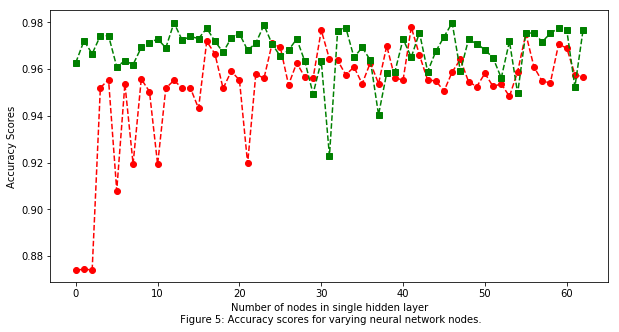

In [17]:
# Analyze the accuracy for different number of nodes in a single hidden layer
# looking for trends
nnt=[]
nnid=[]
for xyz in range (1,65):
    nn_test = MLPClassifier(hidden_layer_sizes=(xyz,),activation ='tanh')
    nn_test_id = MLPClassifier(hidden_layer_sizes=(xyz,),activation ='identity')
    nn_test.fit(X_train,Y_train)
    nn_test_id.fit(X_train,Y_train)
    t=nn_test.score(X_test,Y_test),
    tid=nn_test_id.score(X_test,Y_test)
    nnt.append(t)
    nnid.append(tid)
   # print('Node %d \t TANH score %.6f \t IDENTITY score %.6f'%(xyz,nn_test.score(X_test,Y_test),
                                                              #nn_test_id.score(X_test,Y_test)))

    plt.figure(5,figsize=(10,5))
plt.plot(nnt[1:],'--ro',nnid[1:],'--gs')
plt.xlabel('Number of nodes in single hidden layer\n Figure 5: Accuracy scores for varying neural network nodes.')
plt.ylabel('Accuracy Scores')
plt.show()

In [18]:
# Neural Network from scikit - learn
# TAHN activation
nn_start = time.time()

nn = MLPClassifier(hidden_layer_sizes=(55,),activation='tanh')

# Fit the classifier on the training dataset
nn.fit(X_train, Y_train)

nn_fit_t = time.time()

# Predict the classification for each pixel in image
nn_Y_predAa = nn.predict(image_classAa)
nn_Y_predAb = nn.predict(image_classAb)
nn_Y_predBa = nn.predict(image_classBa)
nn_Y_predBb = nn.predict(image_classBb)

nn_pred_t = time.time()

# Reshape the to view image
nn_Y_whole = np.append(nn_Y_predAa,nn_Y_predAb)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBa)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBb)
nn_img = nn_Y_whole.reshape(l,w)

# Accuracy score using the test set data
nn_score = nn.score(X_test,Y_test)

# Calculate the percent coverage for each class
nn_cl, nn_cnt = np.unique(nn_img, return_counts = True)
nn_perc_cov = nn_cnt/(l*w)

In [19]:
# Calculate time and space efficency for NN
print('The time it took to fit the NN classification model with the training data: %.6f seconds'%(nn_fit_t-nn_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(nn_pred_t-nn_fit_t))
print('The time it took to run the NN classification method: %.6f seconds'%(nn_pred_t-nn_start))
print('The number of classes in this image: %s'%(np.unique(nn_Y_whole)))

The time it took to fit the NN classification model with the training data: 6.816658 seconds
The time it took to predict the image classification matrix: 65.079934 seconds
The time it took to run the NN classification method: 71.896592 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


In [20]:
# IDENTITY activation
nn_start = time.time()

nnID = MLPClassifier(hidden_layer_sizes=(30,), activation='identity')

# Fit the classifier on the training dataset
nnID.fit(X_train, Y_train)

nn_fit_t = time.time()

# Predict the classification for each pixel in image
nn_Y_predAa = nnID.predict(image_classAa)
nn_Y_predAb = nnID.predict(image_classAb)
nn_Y_predBa = nnID.predict(image_classBa)
nn_Y_predBb = nnID.predict(image_classBb)

nn_pred_t = time.time()

# Reshape to display image
nn_Y_whole = np.append(nn_Y_predAa,nn_Y_predAb)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBa)
nn_Y_whole = np.append(nn_Y_whole,nn_Y_predBb)
nnID_img = nn_Y_whole.reshape(l,w)

# Accuracy score using the test set data
nnID_score = nnID.score(X_test,Y_test)

# Calculate the percent coverage for each class
nnID_cl, nnID_cnt = np.unique(nnID_img, return_counts = True)
nnID_perc_cov = nnID_cnt/(l*w)

In [21]:
# Calculate time and space efficency for NN
print('The time it took to fit the NN classification model with the training data: %.6f seconds'%(nn_fit_t-nn_start))
print('The time it took to predict the image classification matrix: %.6f seconds'%(nn_pred_t-nn_fit_t))
print('The time it took to run the NN classification method: %.6f seconds'%(nn_pred_t-nn_start))
print('The number of classes in this image: %s'%(np.unique(nnID_img)))

The time it took to fit the NN classification model with the training data: 7.914196 seconds
The time it took to predict the image classification matrix: 15.327998 seconds
The time it took to run the NN classification method: 23.242194 seconds
The number of classes in this image: [1 2 3 4 5 6 7]


#### 2.2.6 Algorithm Accuracy Assessment 
Each algorithm requires individual assessment before being compared to each other and to the PCI software model. Therefore, based on similar studies, there were various accuracy tests conducted. These included: the scikit-learn built in accuracy score, the confusion matrix and its calculated accuracy score, stratified cross validation mean accuracy score, the kappa coefficient, precision, recall, F-measure, and the Producer's and User's accuracy scores. Some of these accuracy measurements come from the field of machine learning while others come from the field of geography.

First, the built in scikit-learn score function was compared to the accuracy score calculated from the confusion matrix.  The accuracy score determined with the scikit-learn score function takes the test set, 30% of the sample sites, and compares them to the algorithm's actual output. It then returns the mean accuracy value for all classes[5]. A confusion matrix is a particularly useful visualization and calculation tool for multiple accuracy statistics and overall accuracy assessment. Particularly, it represents the best way to determine errors of commission and emission alongside correct classification [21]. The confusion matrix also takes in the same test set and each instance is counted once. The values appearing in the diagonal of the matrix represent the correctly classified pixels and the values outside of this diagonal represent the values which were misclassified. The sum of the diagonal divided by the total sum of pixels in the confusion matrix is the final accuracy score.

In [22]:
# Calculate and save the accuracy values here to display in results

# Calculate the confusion matrix for each classification method and display side by side
mle_test = mle.predict(X_test)
svc_test = svc.predict(X_test)
poly_test = poly.predict(X_test)
nn_test = nn.predict(X_test)
nnID_test = nnID.predict(X_test)

# MLE confusion matrix
mle_con_mx = confusion_matrix(Y_test, mle_test)
# SVC confusion matrix
svc_con_mx = confusion_matrix(Y_test, svc_test)
poly_con_mx = confusion_matrix(Y_test, poly_test)
# Neural network confusion matrix
nn_con_mx = confusion_matrix(Y_test, nn_test)
nnID_con_mx = confusion_matrix(Y_test, nnID_test)

# Calculate accuracy score based on (diagonal /total samples)
mle_diag = np.diag(mle_con_mx)
svc_diag = np.diag(svc_con_mx)
poly_diag = np.diag(poly_con_mx)
nn_diag = np.diag(nn_con_mx)
nnID_diag = np.diag(nnID_con_mx)
pci_diag = np.diag(pci_con_mx)
            
acc_mle = np.sum(mle_diag)/np.sum(mle_con_mx)
acc_svc = np.sum(svc_diag)/np.sum(svc_con_mx)
acc_poly = np.sum(poly_diag)/np.sum(poly_con_mx)
acc_nn = np.sum(nn_diag)/np.sum(nn_con_mx)
acc_nnID = np.sum(nnID_diag)/np.sum(nnID_con_mx)

As the above accuracy scores only considers the test set which, although sufficiently randomized, does not take into account that the uneven pixel distribution for each feature class. For this reason stratified cross validation was considered using 5 folds to determine the average accuracy score based on different training and test sets [16]. Stratification more evenly distributes the training and test classes across all 7 possible features instead of skewing the data toward a single class. For example, since the water class has much more sample pixels the algorithm could be trained very well for water but not as good for other classes. Stratified cross validation will attempt to prevent this from happening. 

In [23]:
# Be rid of warnings for the precision, recall, and f-measure function calls
# Perform stratified k-fold cross validation

# function from https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression
def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

# Perform Stratified k-fold cross validation
shuffle = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scoring = ['precision_macro','recall_macro','accuracy','f1_macro']
scores_mle_all, scores_svc_all, scores_poly_all, scores_nn_all, scores_nnID_all = {},{},{},{},{}
skf = StratifiedKFold(n_splits=5)
for train, test in skf.split(X, Y):
    scores_mle = cross_validate(mle, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_mle_all = merge_two_dicts(scores_mle_all, scores_mle)
    
    scores_svc = cross_validate(svc, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_svc_all = merge_two_dicts(scores_svc_all, scores_svc)
    scores_poly = cross_validate(poly, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_poly_all = merge_two_dicts(scores_poly_all, scores_poly)
    
    scores_nn = cross_validate(nn, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_nn_all = merge_two_dicts(scores_nn_all, scores_nn)
    scores_nnID = cross_validate(nnID, X[train], Y[train], cv=shuffle, scoring=scoring, return_train_score=True)  
    scores_nnID_all = merge_two_dicts(scores_nnID_all, scores_nnID)

Another accuracy statistic which can be extracted from the confusion matrix is the Producer's and User's accuracy for each individual class. The Producer's accuracy is based on the reference data, errors of emission (exclusion), and the User's accuracy is based on the classified data, errors of commission (inclusion)[21,22]. The probability that a reference pixel is labelled correctly is Producer's accuracy which is easily calculated by taking the number of correctly classified pixels for each class and dividing it by the sum of the pixels within that column. Similarly, the User's accuracy is calculated by taking the number of correctly classified pixels and dividing it by the sum of the pixels within that row, and is the probability that a pixel's classification accurately represents the ground truth [22].

In [24]:
# Calculate the Producer's (column) and User's (row) Accuracy for each class
mle_prod = np.round((mle_diag/np.sum(mle_con_mx,axis=0))*100,4)
mle_user = np.round((mle_diag/np.sum(mle_con_mx,axis=1))*100,4)

svc_prod = np.round((svc_diag/np.sum(svc_con_mx,axis=0))*100,4)
svc_user = np.round((svc_diag/np.sum(svc_con_mx,axis=1))*100,4)
poly_prod = np.round((poly_diag/np.sum(poly_con_mx,axis=0))*100,4)
poly_user = np.round((poly_diag/np.sum(poly_con_mx,axis=1))*100,4)

nn_prod = np.round((nn_diag/np.sum(nn_con_mx,axis=0))*100,4)
nn_user = np.round((nn_diag/np.sum(nn_con_mx,axis=1))*100,4)
nnID_prod = np.round((nnID_diag/np.sum(nnID_con_mx,axis=0))*100,4)
nnID_user = np.round((nnID_diag/np.sum(nnID_con_mx,axis=1))*100,4)

pci_prod = np.round((pci_diag/np.sum(pci_con_mx,axis=0))*100,4)
pci_user = np.round((pci_diag/np.sum(pci_con_mx,axis=1))*100,4)

The kappa coefficient considers how the overall accuracy compares to what would be expected at random; that is, it compares the percentage improvement of the algorithm to a purely random assignment of classes to the model. Perfect agreement is obtained with a value of positive one, zero is obtained when there is no agreement above what was randomly assigned, and complete disagreement is obtained with negative one [20]. So, it quantifies if the classification model is significantly different than random, and can be represented with the following equation:

$$ k = \frac{p_{o}-p_{c}}{1-p_{c}} = \frac{1-p_{o}}{1-p_{c}} $$

where $k$ is the kappa coefficient, $p_{o}$ is the overall accuracy calculated using the confusion matrix, and $p_{e}$ is the hypothetical probability of chance agreement [22].

In [25]:
# Kappa score 
mle_kappa = kappa(Y_test, mle_test, weights=None, allow_off_by_one=False)
svc_kappa = kappa(Y_test, svc_test, weights=None, allow_off_by_one=False)
poly_kappa = kappa(Y_test, poly_test, weights=None, allow_off_by_one=False)
nn_kappa = kappa(Y_test, nn_test, weights=None, allow_off_by_one=False)
nnID_kappa = kappa(Y_test, nnID_test, weights=None, allow_off_by_one=False)

Precision, recall, and F-measure, although more prominent in information retrieval and fraud detection, are considered in this study to better understand the algorithms [24]. Precision is the positive predictive value, and recall is the true positive rate. As there is a trade off between precision and recall, the F-measure is used to balance the two and is defined as a harmonic mean [13,24]. The following equation defines the F-measure:

$$ F = 2 * \frac{p*r}{p+r} $$

where $F$ is the F-measure, $p$ is precision, and $r$ is recall [13]. 

In [26]:
# Calculate F-measure, precision, and recall 

p_mle, r_mle, f_mle, s_mle = precision_recall_fscore_support(Y_test,mle_test)
p_mle,r_mle,f_mle = p_mle.round(decimals = 4),r_mle.round(decimals = 4),f_mle.round(decimals = 4)

p_svc, r_svc, f_svc, s_svc = precision_recall_fscore_support(Y_test,svc_test)
p_svc,r_svc,f_svc = p_svc.round(decimals = 4),r_svc.round(decimals = 4),f_svc.round(decimals = 4)
p_poly, r_poly, f_poly, s_poly = precision_recall_fscore_support(Y_test,poly_test)
p_poly,r_poly,f_poly = p_poly.round(decimals = 4),r_poly.round(decimals = 4),f_poly.round(decimals = 4)

p_nn, r_nn, f_nn, s_nn = precision_recall_fscore_support(Y_test,nn_test)
p_nn,r_nn,f_nn = p_nn.round(decimals = 4),r_nn.round(decimals = 4),f_nn.round(decimals = 4)
p_nnID, r_nnID, f_nnID, s_nnID = precision_recall_fscore_support(Y_test,nnID_test)
p_nnID,r_nnID,f_nnID = p_nnID.round(decimals = 4),r_nnID.round(decimals = 4),f_nnID.round(decimals = 4)

#### 2.2.7 Statistical Comparison between Algorithms and to base
Following the individual algorithm accuracy assessment the best parameters for the SVM and NN were chosen and a statistical between algorithm comparison was performed. It was conducted using the McNemar test which considers the errors in classification and the level of disagreement between each algorithm. If two MLA disagree in the same way then the statistic returned will show that there is not a significant difference between the algorithms. If the two MLA disagree differently then the statistic will show there is a significant difference between them. The levels of disagreement are obtained using a contingency table outlined in Table 3 which requires binary metrics of True or False values based on correctly or incorrectly classified pixels. The test uses the True/False and False/True values (Table 3) to derive a chi-square statistic and a p-value of statistical significance [25].

Table 3: Contingency table example.

|MLA  |MLA 2                |MLA 2         |
|-----|---------------------|--------------|
|MLA 1|     True/True       | True/False   |
|MLA 1|     False/True      |False/False   |

In [27]:
# Use this loop for McNemar comparison
mcnemar_table = np.zeros([ls,4])
idx = 0

# Create a binary table of True and falsely classified pixels
for i in range(l):
    for j in range(w):   
        cl = sites[i,j]
        if cl>0:
            if mle_img[i,j] == cl:
                mcnemar_table[idx,0] = 1
            if poly_img[i,j] == cl:
                mcnemar_table[idx,1] = 1
            if nnID_img[i,j] == cl:
                mcnemar_table[idx,2] = 1
            if MLE_image[i,j] == cl:
                mcnemar_table[idx,3] = 1
            idx +=1

In [28]:
# Create Contingency Table from binary table
ms_tp, ms_fp, ms_tn, ms_fn = 0,0,0,0
mp_tp, mp_fp, mp_tn, mp_fn = 0,0,0,0
mn_tp, mn_fp, mn_tn, mn_fn = 0,0,0,0
sp_tp, sp_fp, sp_tn, sp_fn = 0,0,0,0
sn_tp, sn_fp, sn_tn, sn_fn = 0,0,0,0
np_tp, np_fp, np_tn, np_fn = 0,0,0,0

# Extract the True/False and False/True portions of the table
ms_bin = mcnemar_table[:,0]-mcnemar_table[:,1]
ms_fp = np.absolute(np.sum(ms_bin[ms_bin==1]))
ms_fn = np.absolute(np.sum(ms_bin[ms_bin==-1]))

mp_bin = mcnemar_table[:,0]-mcnemar_table[:,3]
mp_fp = np.absolute(np.sum(mp_bin[mp_bin==1]))
mp_fn = np.absolute(np.sum(mp_bin[mp_bin==-1]))

mn_bin = mcnemar_table[:,0]-mcnemar_table[:,2]
mn_fp = np.absolute(np.sum(mn_bin[mn_bin==1]))
mn_fn = np.absolute(np.sum(mn_bin[mn_bin==-1]))

sp_bin = mcnemar_table[:,1]-mcnemar_table[:,3]
sp_fp = np.absolute(np.sum(sp_bin[sp_bin==1]))
sp_fn = np.absolute(np.sum(sp_bin[sp_bin==-1]))

sn_bin = mcnemar_table[:,1]-mcnemar_table[:,2]
sn_fp = np.absolute(np.sum(sn_bin[sn_bin==1]))
sn_fn = np.absolute(np.sum(sn_bin[sn_bin==-1]))

np_bin = mcnemar_table[:,2]-mcnemar_table[:,3]
np_fp = np.absolute(np.sum(np_bin[np_bin==1]))
np_fn = np.absolute(np.sum(np_bin[np_bin==-1]))

# Extract True/True and False/False
for mi in mcnemar_table:
    # mle vs svc
    if mi[0]==1 and mi[1]==1:
        ms_tp +=1
    if mi[0]==0 and mi[1]==0:
        ms_tn += 1
     # mle vs nn
    if mi[0]==1 and mi[2]==1:
        mn_tp +=1
    if mi[0]==0 and mi[2]==0:
        mn_tn += 1
     # mle vs pci
    if mi[0]==1 and mi[3]==1:
        mp_tp +=1
    if mi[0]==0 and mi[3]==0:
        mp_tn += 1
     # svc vs nn
    if mi[1]==1 and mi[2]==1:
        sn_tp +=1
    if mi[1]==0 and mi[2]==0:
        sn_tn += 1
     # svc vs pci
    if mi[1]==1 and mi[3]==1:
        sp_tp +=1
    if mi[1]==0 and mi[3]==0:
        sp_tn += 1
    # nn vs pci
    if mi[2]==1 and mi[3]==1:
        np_tp +=1
    if mi[2]==0 and mi[3]==0:
        np_tn += 1

## 3. Results and Discussion
### 3.1 Descriptive Statistics and Signature Separability measures
Descriptive statistics for each spectral band will vary depending on the spectral resolution. The descriptive statistics were used to ensure that there were no erroneous values or any bands which should not be considered due to preprocessing errors. Also, please note that statistics and output may change slightly when code is rerun based on the randomized train/test split.

It was determined with the signature separability that the samples chosen were sufficient to use for classification. A measure over 1.86 for the Bhattacharyya distance, and over 1.95 for the transformed divergence is above the required 1.8 which determines suitable separability (Fig.6 & Fig.7). Each separability measure determined different classes which would be difficult to separate. Bhattacharyya distance determined that shrub and wetland would be the most difficult to separate, and transformed divergence determined that forest and shrub would be the most difficult. It may be possible that these classes have more classification errors than other classes.

Band #1: Minimum=0.000, Maximum=0.000, Mean=719.625, Standard Deviation=551.897
Band #2: Minimum=1008.000, Maximum=2573.000, Mean=1160.923, Standard Deviation=78.239
Band #3: Minimum=656.000, Maximum=6087.000, Mean=832.732, Standard Deviation=111.000
Band #4: Minimum=393.000, Maximum=5761.000, Mean=597.282, Standard Deviation=158.194
Band #5: Minimum=198.000, Maximum=7323.000, Mean=365.727, Standard Deviation=197.341
Band #6: Minimum=157.000, Maximum=6220.000, Mean=483.101, Standard Deviation=301.141
Band #7: Minimum=121.000, Maximum=6526.000, Mean=978.969, Standard Deviation=790.413
Band #8: Minimum=119.000, Maximum=6788.000, Mean=1169.910, Standard Deviation=1002.647
Band #9: Minimum=86.000, Maximum=7795.000, Mean=1122.960, Standard Deviation=1021.890
Band #10: Minimum=71.000, Maximum=7501.000, Mean=1284.588, Standard Deviation=1155.643
Band #11: Minimum=29.000, Maximum=1701.000, Mean=303.167, Standard Deviation=252.365


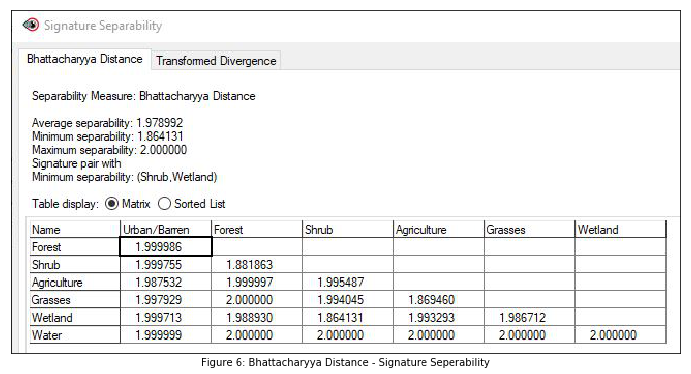

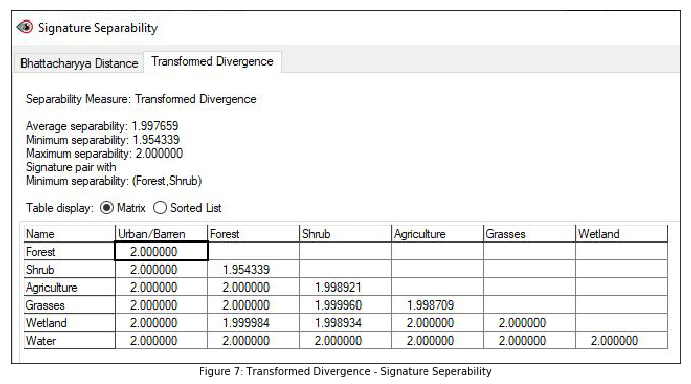

In [29]:
# Print descriptive statistics for each band
numB = 0
for numB in range(0,11):
    print("Band #%d: Minimum=%.3f, Maximum=%.3f, Mean=%.3f, Standard Deviation=%.3f"%(numB+1,stats_all[numB,0],
                                                                                      stats_all[numB,1], 
                                                                                      stats_all[numB,2],
                                                                                      stats_all[numB,3]))
    numB += 1
    
plt.figure(6, figsize=(12,12))
plt.xlabel('Figure 6: Bhattacharyya Distance - Signature Seperability')
plt.xticks([])
plt.yticks([])
plt.imshow(bhat_dist)

plt.figure(7, figsize=(12,12))
plt.xlabel('Figure 7: Transformed Divergence - Signature Seperability')
plt.xticks([])
plt.yticks([])
plt.imshow(trans_dive)

### 3.2 Algorithm Accuracy Assessment

It was confirmed that each of the MLA’s considered were able to identify all seven classes, but upon visual inspection there are significant differences between each classification model. This section assesses the individual accuracy of each model for comparison. Section 3.3 considers the statistical difference between algorithms. 

Visually, it appears that water is classified well in most classification models. The PCI MLE output contains some misclassified pixels within Shawnigan Lake (in the centre of the study area) and in the ocean along the southern part of the study area. Regardless of these misclassified pixels, the PCI MLE resulted in an accuracy score of 99.32%. As most of the study area is made up of forest or water, these classes appear to dominate the PCI MLE output. This fact is also true for the Python MLE and both SVM classification models. Interestingly, there are significant differences between these and the NN outputs. It appears that both NN classification models are lacking in complexity. Although the NN classifications, appear to classify water well, they also appear to pick up noise within the forest features. The NN models appear to overestimate forest and underestimate urban, shrub, and wetland features. It appears that the NN with the identity activation resulted in a more complex surface than the NN with the tahn activation. For this reason the identity activation function NN will be considered more extensively for the statistical between MLA comparison. Although the NN did not result in very similar classification models to the other MLA's its accuracy is sufficient at 97.02%. Such a high accuracy score raises concerns of overestimating accuracy when visually it does not appear to classify well. 

Although the NN outputs were quite different, the MLE and SVM classification models were more similar visually. The MLE had an accuracy score which was lower than the other MLA’s with 96.67%. Although this is still considered quite high, it appears to estimate more urban features than SVM and NN. The SVM using a linear kernel performed well, and quickly, with an accuracy of 99.13%, but the polynomial kernel performed slightly better with 99.84%. Although this algorithm was slower, it has a higher overall accuracy and was chosen for the statistical between algorithm comparison. The NN were extremely fast, but limitations lay in the selection of correct hyperparameters for the algorithm. As these parameters change between the studies found in other literature, this project was limited to informed trial and error [15,17,18]. As was the case with the varying SVM parameters, but the SVM were regarded to be more visually complex than the NN. 

When compared to the PCI MLE, the Python MLE algorithm visually performs better. In fact, the accuracy score calculated using the confusion matrix derived by analyzing 40 randomly selected pixels (on PCI software) only returns a 75% accuracy score. The confusion matrices for the MLE, SVM, and NN algorithms are more robust than the PCI MLE confusion matrix because they are made up 30% of the training samples, or 44,296 pixels. Therefore, the PCI MLE confusion matrix accuracy score is not as reliable as the MLE, SVM, or NN. The accuracy scores computed using the confusion matrices for these algorithms resulted in the same accuracy which was computed using scikit-learn’s built in functions.

Ultimately when comparing overall accuracy scores for the individual output classification models, the algorithms are ranked as follows: 1) SVM polynomial kernel, 2) PCI MLE, 3) SVM linear kernel, 4) NN identity activation function, 5) MLE, 6) NN tahn activation function. It must be considered that it is possible that all algorithm are overestimating accuracy due to the pixel based classification method and pixel adjacency. At a first glance the SVM with a 3rd order polynomial function performed the best. The following considers this in more depth. 

In [30]:
# Difference in accuracy scores 
func_scores = np.array([mle_score,svc_score,poly_score,nn_score,nnID_score])
acc_scores = np.array([acc_mle,acc_svc,acc_poly,acc_nn,acc_nnID])
print('The differene in accuracy scores is: ',func_scores - acc_scores)

The differene in accuracy scores is:  [0. 0. 0. 0. 0.]


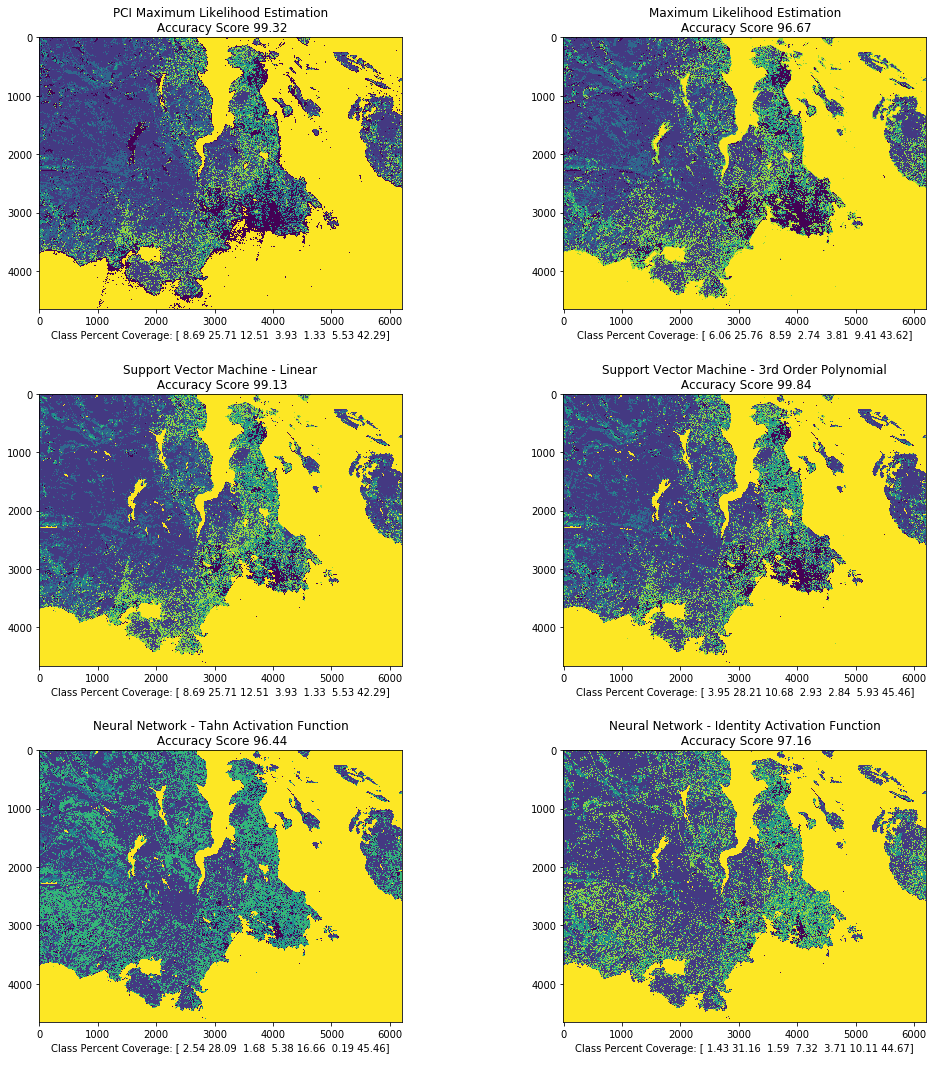

In [31]:
# Display all land classification maps considered 
# !!!!! Kappa Accuracy Scores

plt.figure(8, figsize=(15,15))
plt.subplot(321)
plt.title('PCI Maximum Likelihood Estimation\n Accuracy Score %.2f'%(pci_score*100))
plt.xlabel('Class Percent Coverage: %s\n'%(np.round(pci_perc_cov, 4)*100))
plt.imshow(MLE_image)

plt.subplot(322)
plt.title('Maximum Likelihood Estimation\n Accuracy Score %.2f'%(mle_score*100))
plt.xlabel('Class Percent Coverage: %s\n'%(np.round(mle_perc_cov, 4)*100))
plt.imshow(mle_img)

plt.subplot(323)
plt.title('Support Vector Machine - Linear\n Accuracy Score %.2f'%(svc_score*100))
plt.xlabel('Class Percent Coverage: %s\n'%(np.round(pci_perc_cov, 4)*100))
plt.imshow(svc_img)

plt.subplot(324)
plt.title('Support Vector Machine - 3rd Order Polynomial\n Accuracy Score %.2f'%(poly_score*100))
plt.xlabel('Class Percent Coverage: %s\n'%(np.round(poly_perc_cov, 4)*100))
plt.imshow(poly_img)

plt.subplot(325)
plt.title('Neural Network - Tahn Activation Function\n Accuracy Score %.2f'%(nn_score*100))
plt.xlabel('Class Percent Coverage: %s\n'%(np.round(nn_perc_cov, 4)*100))
plt.imshow(nn_img)

plt.subplot(326)
plt.title('Neural Network - Identity Activation Function\n Accuracy Score %.2f'%(nnID_score*100))
plt.xlabel('Class Percent Coverage: %s\n'%(np.round(nnID_perc_cov, 4)*100))
plt.imshow(nnID_img)

plt.tight_layout()

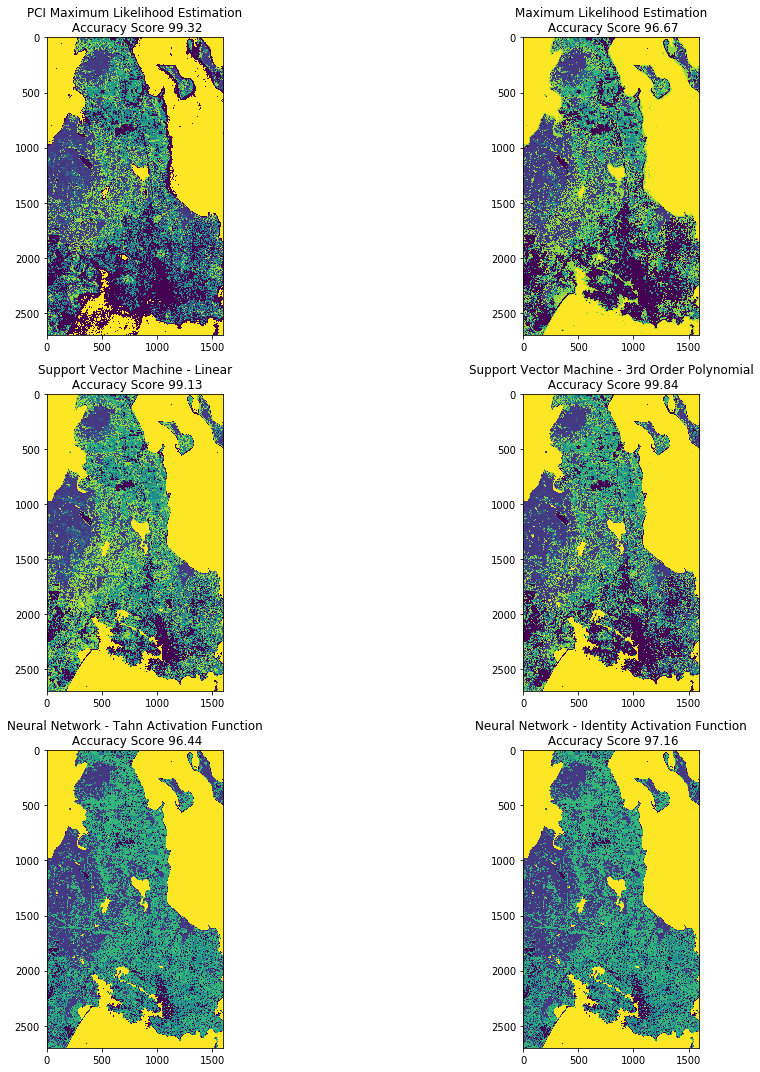

In [32]:
# Display zoomed in section of the pennisula
plt.figure(9, figsize=(15,15))
plt.subplot(321)
plt.title('PCI Maximum Likelihood Estimation\n Accuracy Score %.2f'%(pci_score*100))
plt.imshow(MLE_image[800:3500,3000:4600])

plt.subplot(322)
plt.title('Maximum Likelihood Estimation\n Accuracy Score %.2f'%(mle_score*100))
plt.imshow(mle_img[800:3500,3000:4600])

plt.subplot(323)
plt.title('Support Vector Machine - Linear\n Accuracy Score %.2f'%(svc_score*100))
plt.imshow(svc_img[800:3500,3000:4600])

plt.subplot(324)
plt.title('Support Vector Machine - 3rd Order Polynomial\n Accuracy Score %.2f'%(poly_score*100))
plt.imshow(poly_img[800:3500,3000:4600])

plt.subplot(325)
plt.title('Neural Network - Tahn Activation Function\n Accuracy Score %.2f'%(nn_score*100))
plt.imshow(nn_img[800:3500,3000:4600])

plt.subplot(326)
plt.title('Neural Network - Identity Activation Function\n Accuracy Score %.2f'%(nnID_score*100))
plt.imshow(nn_img[800:3500,3000:4600])

plt.tight_layout()

To understand if the overall accuracy score mentioned above may be overestimating accuracy, stratified k-fold cross validation was performed to gather a better understand of the algorithm’s actual performance. Five folds were considered for the cross validation and it was stratified to ensure a more equal distribution for training across all features. The average accuracy for the SVM 3rd order polynomial kernel was the highest, and rounds to 100%. The box plot indicates that there was not much for a range of accuracy values for this algorithm (Fig.10). Conversely, the NN algorithms had a much larger range of values with a minimum of 95% which is still very good. The ranking of average accuracy scores differs from the overall accuracy scores, and is: 1) SVM polynomial kernel, 2) SVM linear kernel, 3) MLE, 4) PCI MLE, 5) NN identity activation function, 6) NN tahn activation function. Interestingly, the MLE ranks higher in the average cross validation score, which leads to believe that the stratification, or distribution of training pixels, effects the output.

PCI Maximum Likelihood Estimation Mean Accuracy: 97.38
Maximum Likelihood Estimation Mean Accuracy: 97.80
Support Vector Machine - Linear - Mean Accuracy: 99.44
Support Vector Machine - Polynomial - Mean Accuracy: 99.92
Neural Network - Tahn - Mean Accuracy: 96.06
Neural Network - Identity- Mean Accuracy: 97.38


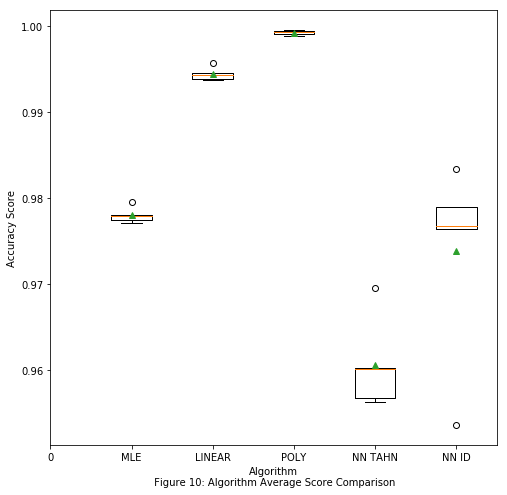

In [33]:
# Dispaly cross validation data

mle_cross = scores_mle_all['test_accuracy']#'train_accuracy']
svc_cross = scores_svc_all['test_accuracy']#'train_accuracy']
poly_cross = scores_poly_all['test_accuracy']#'train_accuracy']
nn_cross = scores_nn_all['test_accuracy']#'train_accuracy']
nnID_cross = scores_nnID_all['test_accuracy']#'train_accuracy']

print('PCI Maximum Likelihood Estimation Mean Accuracy: %.2f'%(pci_score_avg*100))
print('Maximum Likelihood Estimation Mean Accuracy: %.2f'%(np.average(mle_cross)*100))
print('Support Vector Machine - Linear - Mean Accuracy: %.2f'%(np.average(svc_cross)*100))
print('Support Vector Machine - Polynomial - Mean Accuracy: %.2f'%(np.average(poly_cross)*100))
print('Neural Network - Tahn - Mean Accuracy: %.2f'%(np.average(nn_cross)*100))
print('Neural Network - Identity- Mean Accuracy: %.2f'%(np.average(nnID_cross)*100))

plt.figure(10,figsize=(8,8))
plt.boxplot([mle_cross,svc_cross,poly_cross,nn_cross,nnID_cross], showmeans = True)
plt.xticks([0,1,2,3,4,5],[0,'MLE','LINEAR','POLY','NN TAHN','NN ID',])
plt.xlabel('Algorithm\n Figure 10: Algorithm Average Score Comparison')
plt.ylabel('Accuracy Score')
plt.show()

Confusion matrices are valuable in understanding misclassification, or errors, in the classification models. For example, in the MLE confusion matrix 187 pixels which were supposed to be classified as urban were instead classified as agriculture according to the test set. The SVM confusion matrices exhibit the least errors with the linear kernel having 164 pixels misclassified, and the polynomial kernel having only 31 misclassified pixels. The NN algorithm using tahn activation function does not classify any wetland pixels correctly which coincides with the visual inspection being less complex than necessary. When this code was run previous the NN tahn activation algorithm did not classify shrub correctly either, so with varying train/test splits these two classes are effected. In fact, the Bhattacharyya distance measure of separability assumed that the shrub and wetland were the least distinguishable features. This difficult spectral separability could be why the tahn activation function performed poorly for these features. 

In [34]:
print('PCI Maximum Likelihood Estimation\n 40 Random Samples')
print(pci_con_mx)
print()
print('Maximum Likelihood Estimation')
print(mle_con_mx)
print()
print('Support Vector Machine - Linear')
print(svc_con_mx)
print()
print('Support Vector Machine - 3rd Order Polynomial')
print(poly_con_mx)
print()
print('Neural Network - Tahn Activation')
print(nn_con_mx)
print()
print('Neural Network - Identity Acitvation')
print(nnID_con_mx)
print()

PCI Maximum Likelihood Estimation
 40 Random Samples
[[ 3  0  0  1  0  0  1]
 [ 0  9  1  0  0  0  0]
 [ 0  3  2  0  0  0  0]
 [ 1  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  1  1  0  0  0  0]
 [ 0  0  0  0  0  0 15]]

Maximum Likelihood Estimation
[[  690     0     0   114     0    25     0]
 [    0  2554   140     0     0    11     0]
 [    0     0   160     1     5    20     0]
 [  187     0     0   687    33     0     0]
 [    9     0    27    30   316     0     0]
 [    0     7    22     0     2    53     0]
 [    0     0     0     0     0     0 13892]]

Support Vector Machine - Linear
[[  801     0     0    28     0     0     0]
 [    0  2697     8     0     0     0     0]
 [    0     5   179     1     1     0     0]
 [   44     0     4   836    23     0     0]
 [    1     0     3    37   341     0     0]
 [    0     0    10     0     0    74     0]
 [    0     0     0     0     0     0 13892]]

Support Vector Machine - 3rd Order Polynomial
[[  824     0     0     0     5    

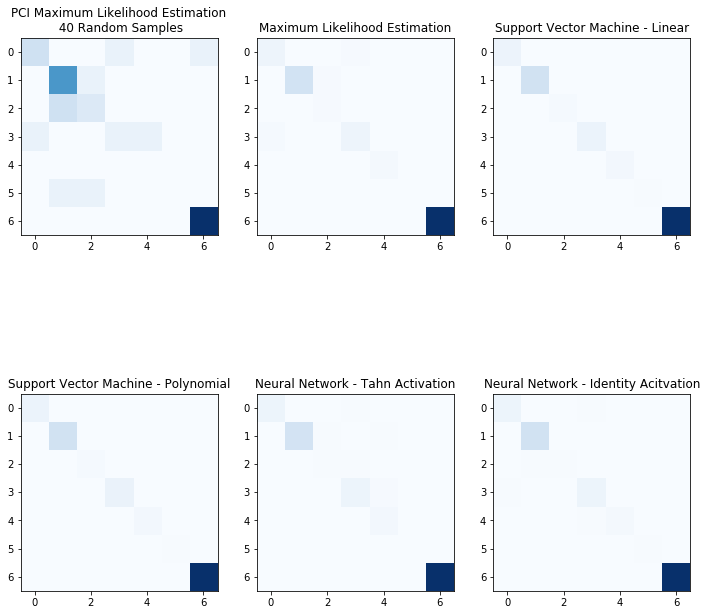

In [35]:
# Display confusion matrices as percentages for better visualization
plt.figure(11, figsize=(12,12))
 
i=1
plt.subplot(2,3,i)
plt.title('PCI Maximum Likelihood Estimation\n 40 Random Samples')
plt.imshow(pci_con_mx/(l*w), cmap="Blues")
    
plt.subplot(2,3,i+1)
plt.title('Maximum Likelihood Estimation')
plt.imshow(mle_con_mx/(l*w), cmap="Blues")
    
plt.subplot(2,3,i+2)
plt.title('Support Vector Machine - Linear')
plt.imshow(svc_con_mx/(l*w), cmap="Blues")
   
plt.subplot(2,3,i+3)
plt.title('Support Vector Machine - Polynomial')
plt.imshow(poly_con_mx/(l*w), cmap="Blues")
    
plt.subplot(2,3,i+4)
plt.title('Neural Network - Tahn Activation')
plt.imshow(nn_con_mx/(l*w), cmap="Blues")
    
plt.subplot(2,3,i+5)
plt.title('Neural Network - Identity Acitvation')
plt.imshow(nnID_con_mx/(l*w), cmap="Blues")

A benefit of a confusion matrix is understanding errors in emission or commission which will be explored in the Producer’s and User’s accuracy scores. These scores explore how well each feature is identified within each MLA. The PCI MLE resulted in nan and 0% for some features as there is division by zero for wetland’s Producer’s accuracy, and grassland’s User’s accuracy scores. This also occurs for some features in the NN algorithm with tahn activation. Interestingly, the water feature class resulted in a Producer’s and User’s accuracy of 100% which could be because there are the most training pixels for this feature. Similar to the accuracy scores described for the SVM 3rd order polynomial, the Producer’s and User’s accuracy for this algorithm was consistently above 93% for all features. In fact, the SVM was the only algorithm which did not see a Producer’s accuracy below 75% and a User’s accuracy below 70%, but the linear kernel did not perform as well as the polynomial. Specific classes which did not perform well varied between algorithms with no particular trends.  

In [36]:
# Calculate Producer's and User's Accuracy from the confusion matrix
# Calculate accuracy score from confusion matrix
print('PCI Maximum Likelihood Estimation')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(pci_prod,4),np.round(pci_user,4)))
print('Maximum Likelihood Estimation')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(mle_prod,4),np.round(mle_user,4)))
print('Support Vector Machine - Linear')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(svc_prod,4),np.round(svc_user,4)))
print('Support Vector Machine - Polynomial')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(poly_prod,4),np.round(poly_user,4)))
print('Neural Network - Tahn Activation')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(nn_prod,4),np.round(nn_user,4)))
print('Neural Network - Identity Activation')
print('Producer\'s Accuracy is: \n%s\n User\'s Accuracy is: \n%s\n'%(np.round(nnID_prod,4),np.round(nnID_user,4)))

PCI Maximum Likelihood Estimation
Producer's Accuracy is: 
[75.     69.2308 50.     50.      0.         nan 93.75  ]
 User's Accuracy is: 
[ 60.      90.      40.      33.3333      nan   0.     100.    ]

Maximum Likelihood Estimation
Producer's Accuracy is: 
[ 77.8781  99.7267  45.8453  82.5721  88.764   48.6239 100.    ]
 User's Accuracy is: 
[ 83.2328  94.4177  86.0215  75.7442  82.7225  63.0952 100.    ]

Support Vector Machine - Linear
Producer's Accuracy is: 
[ 94.6809  99.815   87.7451  92.6829  93.4247 100.     100.    ]
 User's Accuracy is: 
[ 96.6224  99.7043  96.2366  92.172   89.267   88.0952 100.    ]

Support Vector Machine - Polynomial
Producer's Accuracy is: 
[ 99.8788  99.8521  93.1937  99.7792  97.9167  96.3855 100.    ]
 User's Accuracy is: 
[ 99.3969  99.8152  95.6989  99.6692  98.4293  95.2381 100.    ]

Neural Network - Tahn Activation
Producer's Accuracy is: 
[ 96.5116  98.545   43.662   77.9643  52.9412   0.     100.    ]
 User's Accuracy is: 
[ 90.1086  92.6433

It was statistically determined that the kappa coefficient for all algorithms are close to positive one (or 100%), so they are sufficiently different from a random distribution. Intriguingly, the kappa coefficients for the SVM algorithms remained relatively similar to the overall mean accuracy scores, whereas, the MLE and NN deceased in value. The PCI MLE kappa coefficient increased as well, but this value was determined using PCI Geomatica internal tools so it cannot be said with certainty how it was derived. 

In [37]:
# Display Kappa Coefficient
print('PCI Maximum Likelihood Estimation Kappa Score: %.2f'%(pci_kappa*100))
print('Maximum Likelihood Estimation Kappa Score: %.2f'%(mle_kappa*100))
print('Support Vector Machine - Linear - Kappa Score: %.2f'%(svc_kappa*100))
print('Support Vector Machine - Polynomial - Kappa Score: %.2f'%(poly_kappa*100))
print('Neural Network - Tahn - Kappa Score: %.2f'%(nn_kappa*100))
print('Neural Network - Identiy - Kappa Score: %.2f'%(nnID_kappa*100))

PCI Maximum Likelihood Estimation Kappa Score: 98.47
Maximum Likelihood Estimation Kappa Score: 92.43
Support Vector Machine - Linear - Kappa Score: 98.02
Support Vector Machine - Polynomial - Kappa Score: 99.63
Neural Network - Tahn - Kappa Score: 91.93
Neural Network - Identiy - Kappa Score: 93.53


Water’s F-measure, for every algorithm, resulted in a value of 100% which means the water feature class has perfect precision and recall, most likely because this sample set has the most training pixels. The MLE F-measure ranges from 54.92% to 85.64% with the lowest being for shrub and wetland and the highest for forest and grassland. It is interesting that grassland ranked so high because finding homogenous training sites was difficult. A lower F-measure when compared to the overall accuracy score for MLE was also found in previous studies [24]. The SVM algorithms performed the best with F-measure’s greater than 91.30% for all feature classes. In fact for the SVM 3rd order polynomial kernel, the forest class had perfect recall and nearly perfect precision. The NN tahn activation function algorithm is lacking test output from wetland (and in some train/test splits shrub), so the F-measure of 0% is not surprising. These classes also resulted in the lowest F-measure for the NN identity activation function algorithm. Consequently, the precision for wetland classes was above 32.12%, but the recall was 73.81% so the true positive rate is quite low. 

Previous studies considered the F-measure as prevalent as the overall accuracy score so the average F-measure from the stratified k-fold cross validation was considered [24]. The ranking of algorithms based on average F-measure is the same order as the average overall accuracy results. Unfortunately, the NN algorithm performed much more poorly when considering the average F-measure. So much so, it can be said it results in an insufficient classification model.

In [48]:
# Consider the F-Measure, recall, and precision
# Determine which classes are missing for test sets
print('MLE missing class: %s'%(set(Y_test)-set(mle_test)))
print('SVM linear missing class: %s'%(set(Y_test)-set(svc_test)))
print('SVM polynomial missing class: %s'%(set(Y_test)-set(poly_test)))
print('NN tahn missing class: %s'%(set(Y_test)-set(nn_test)))
print('NN identity missing class: %s\n'%(set(Y_test)-set(nnID_test)))

print('Maximum Likelihood Estimation')
print('Precision:\n%s\n Recall:\n%s\n F-Measure\n%s\n'%(p_mle,r_mle,f_mle))

print('Support Vector Machine - Linear')
print('Precision:\n%s\n Recall:\n%s\n F-Measure\n%s\n'%(p_svc,r_svc,f_svc))
print('Support Vector Machine - 3rd Order Polynomail')
print('Precision:\n%s\n Recall:\n%s\n F-Measure\n%s\n'%(p_poly,r_poly,f_poly))

print('Neural Network - Tahn Activation')
print('Precision:\n%s\n Recall:\n%s\n F-Measure\n%s\n'%(p_nn,r_nn,f_nn))
print('Neural Network - Identity Activation')
print('Precision:\n%s\n Recall:\n%s\n F-Measure\n%s\n'%(p_nnID,r_nnID,f_nnID))

MLE missing class: set()
SVM linear missing class: set()
SVM polynomial missing class: set()
NN tahn missing class: set()
NN identity missing class: set()

Maximum Likelihood Estimation
Precision:
[0.7788 0.9973 0.4585 0.8257 0.8876 0.4862 1.    ]
 Recall:
[0.8323 0.9442 0.8602 0.7574 0.8272 0.631  1.    ]
 F-Measure
[0.8047 0.97   0.5981 0.7901 0.8564 0.5492 1.    ]

Support Vector Machine - Linear
Precision:
[0.9468 0.9981 0.8775 0.9268 0.9342 1.     1.    ]
 Recall:
[0.9662 0.997  0.9624 0.9217 0.8927 0.881  1.    ]
 F-Measure
[0.9564 0.9976 0.9179 0.9243 0.913  0.9367 1.    ]

Support Vector Machine - 3rd Order Polynomail
Precision:
[0.9988 0.9985 0.9319 0.9978 0.9792 0.9639 1.    ]
 Recall:
[0.994  0.9982 0.957  0.9967 0.9843 0.9524 1.    ]
 F-Measure
[0.9964 0.9983 0.9443 0.9972 0.9817 0.9581 1.    ]

Neural Network - Tahn Activation
Precision:
[0.9651 0.9855 0.4366 0.7796 0.5294 0.     1.    ]
 Recall:
[0.9011 0.9264 0.3333 0.8192 0.9424 0.     1.    ]
 F-Measure
[0.932  0.955  

Maximum Likelihood Estimation Mean Accuracy: 83.79
Support Vector Machine - Linear - Mean Accuracy: 96.18
Support Vector Machine - Polynomial - Mean Accuracy: 98.86
Neural Network - Tahn - Mean Accuracy: 57.58
Neural Network - Identity- Mean Accuracy: 76.96


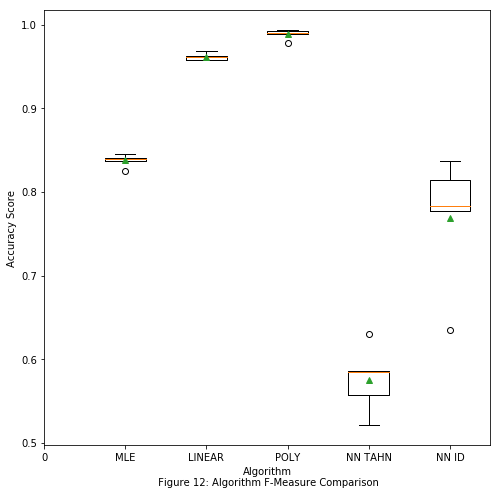

In [39]:
# Average F-measures for each MLA
mle_F = scores_mle_all['test_f1_macro']
svc_F = scores_svc_all['test_f1_macro']
poly_F = scores_poly_all['test_f1_macro']
nn_F = scores_nn_all['test_f1_macro']
nnID_F = scores_nnID_all['test_f1_macro']

print('Maximum Likelihood Estimation Mean Accuracy: %.2f'%(np.average(mle_F)*100))
print('Support Vector Machine - Linear - Mean Accuracy: %.2f'%(np.average(svc_F)*100))
print('Support Vector Machine - Polynomial - Mean Accuracy: %.2f'%(np.average(poly_F)*100))
print('Neural Network - Tahn - Mean Accuracy: %.2f'%(np.average(nn_F)*100))
print('Neural Network - Identity- Mean Accuracy: %.2f'%(np.average(nnID_F)*100))

plt.figure(12,figsize=(8,8))
plt.boxplot([mle_F,svc_F,poly_F,nn_F,nnID_F], showmeans = True)
plt.xticks([0,1,2,3,4,5],[0,'MLE','LINEAR','POLY','NN TAHN','NN ID',])
plt.xlabel('Algorithm\n Figure 12: Algorithm F-Measure Comparison')
plt.ylabel('Accuracy Score')
plt.show()

### 3.3 Comparison Between Algorithms and against PCI Maximum Likelihood Estimation

Six statistical algorithm comparisons were performed between the PCI MLE, the Python MLE, the 3rd order polynomial SVM, and the identity activation function NN MLAs. Each comparison was done using the McNemar Test which takes the True/False and False/True values from a contingency table (Table 3), and derives a chi-square, and p-value [25]. If the p-value result is insignificant (i.e. >0.05) within a certain confidence interval, then the two classification models have errors of the same proportion. It was found, based on the test sample set, each algorithm was statistically significantly different from another with 99% confidence and p-values < 0.0001. Consistently across comparisons, approximately 20% of the pixels classified in one model were not classified the same in the other model. So, although the algorithms resulted in what appears to be only slightly different classification models, their statistical difference means there are no consistent errors across algorithms. In fact, all MLA’s are statistically significantly different from each other which means that the accuracy scores discussed in Section 3.2 should also be considered significantly different. Therefore, it can be stated with certainty that the SVM classifier significantly performed 2.52% better than the PCI MLE classifier, 2.10% better than the Python MLE classifier, and 2.52% better than the NN classifier in the mean accuracy scores.

Comparison between PCI MLE and scikit-learn MLE
McNemar statistic=1530.125, p-value=0.000000
Contingency Table  [61071, 89.0] 
		   [1782.0, 339] 

Percentage of pixels not classified the same 18.79


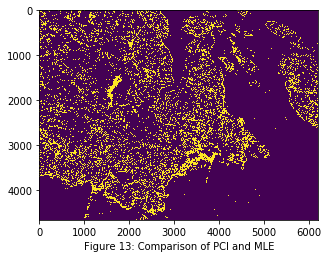

In [40]:
# McNemar Test using confustion matrix
print('Comparison between PCI MLE and scikit-learn MLE')

# MLE vs PCI
mp_table = [[mp_tp, mp_fp],
            [mp_fn, mp_tn]]
mp_result = mcnemar(mp_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (mp_result.statistic, mp_result.pvalue))
print('Contingency Table ',mp_table[0],'\n\t\t  ',mp_table[1],'\n')

# Visualize difference
mp_diff = MLE_image - mle_img
mp_diff1 = np.array([mp_diff != 0])
print('Percentage of pixels not classified the same %.2f'%(np.sum(mp_diff1*1)/(l*w)*100))
plt.figure(13,figsize=(5,5))
plt.xlabel('Figure 13: Comparison of PCI and MLE')
plt.imshow(mp_diff)

Comparison between PCI MLE and SVM - Polynomial
McNemar statistic=336.787, p-value=0.000000
Contingency Table  [62824, 418.0] 
		   [29.0, 10] 

Percentage of pixels not classified the same 17.91


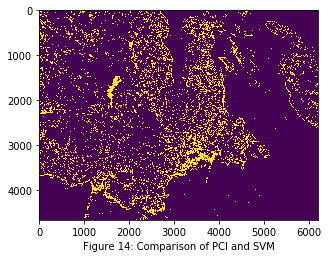

In [41]:
print('Comparison between PCI MLE and SVM - Polynomial')
# SVC vs PCI
sp_table = [[sp_tp, sp_fp],
            [sp_fn, sp_tn]]
sp_result = mcnemar(sp_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (sp_result.statistic, sp_result.pvalue))
print('Contingency Table ',sp_table[0],'\n\t\t  ',sp_table[1],'\n')

sp_diff = MLE_image - poly_img
sp_diff1 = np.array([sp_diff != 0])
print('Percentage of pixels not classified the same %.2f'%(np.sum(sp_diff1*1)/(l*w)*100))
plt.figure(14,figsize=(5,5))
plt.xlabel('Figure 14: Comparison of PCI and SVM')
plt.imshow(sp_diff)

Comparison between PCI MLE and scikit-learn Neural Network
McNemar statistic=1122.699, p-value=0.000000
Contingency Table  [61323, 154.0] 
		   [1530.0, 274] 

Percentage of pixels not classified the same 26.56


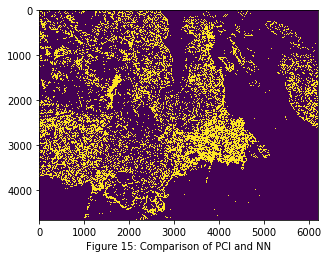

In [42]:
print('Comparison between PCI MLE and scikit-learn Neural Network')
# NN vs PCI
np_table = [[np_tp, np_fp],
            [np_fn, np_tn]]
np_result = mcnemar(np_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (np_result.statistic, np_result.pvalue))
print('Contingency Table ',np_table[0],'\n\t\t  ',np_table[1],'\n')


np_diff=MLE_image - nnID_img
np_diff1 = np.array([np_diff != 0])
print('Percentage of pixels not classified the same %.2f'%(np.sum(np_diff1*1)/(l*w)*100))
plt.figure(15,figsize=(5,5))
plt.xlabel('Figure 15: Comparison of PCI and NN')
plt.imshow(np_diff)

Comparison between scikit-learn MLE and SVM
McNemar statistic=2038.871, p-value=0.000000
Contingency Table  [61139, 21.0] 
		   [2103.0, 18] 

Percentage of pixels not classified the same 19.50


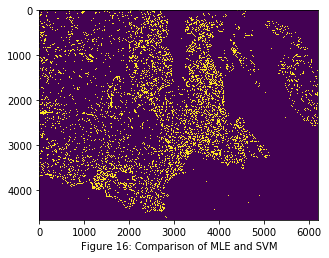

In [43]:
print('Comparison between scikit-learn MLE and SVM')
# MLE vs SVC
ms_table = [[ms_tp, ms_fp],
            [ms_fn, ms_tn]]
ms_result = mcnemar(ms_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (ms_result.statistic, ms_result.pvalue))
print('Contingency Table ',ms_table[0],'\n\t\t  ',ms_table[1],'\n')

ms_diff = mle_img - poly_img
ms_diff1 = np.array([ms_diff != 0])
print('Percentage of pixels not classified the same %.2f'%(np.sum(ms_diff1*1)/(l*w)*100))
plt.figure(16,figsize=(5,5))
plt.xlabel('Figure 16: Comparison of MLE and SVM')
plt.imshow(ms_diff)

Comparison between scikit-learn MLE and NN
McNemar statistic=44.839, p-value=0.000000
Contingency Table  [60205, 955.0] 
		   [1272.0, 849] 

Percentage of pixels not classified the same 22.20


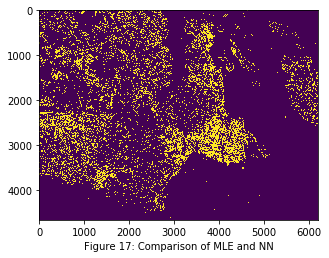

In [44]:
print('Comparison between scikit-learn MLE and NN')
# MLE vs NN
mn_table = [[mn_tp, mn_fp],
            [mn_fn, mn_tn]]
mn_result = mcnemar(mn_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (mn_result.statistic, mn_result.pvalue))
print('Contingency Table ',mn_table[0],'\n\t\t  ',mn_table[1],'\n')

mn_diff = mle_img - nnID_img
mn_diff1 = np.array([mn_diff != 0])
print('Percentage of pixels not classified the same %.2f'%(np.sum(mn_diff1*1)/(l*w)*100))
plt.figure(17,figsize=(5,5))
plt.xlabel('Figure 17: Comparison of MLE and NN')
plt.imshow(mn_diff)

Comparison between scikit-learn SVM and NN
McNemar statistic=1735.469, p-value=0.000000
Contingency Table  [61463, 1779.0] 
		   [14.0, 25] 

Percentage of pixels not classified the same 22.88


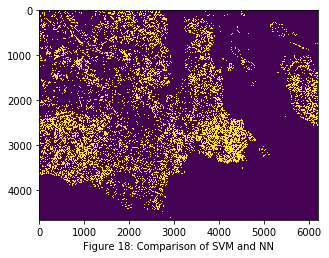

In [45]:
print('Comparison between scikit-learn SVM and NN')
# SVC vs NN
sn_table = [[sn_tp, sn_fp],
            [sn_fn, sn_tn]]
sn_result = mcnemar(sn_table, exact=False, correction=True)
print('McNemar statistic=%.3f, p-value=%f' % (sn_result.statistic, sn_result.pvalue))
print('Contingency Table ',sn_table[0],'\n\t\t  ',sn_table[1],'\n')

sn_diff = poly_img - nnID_img
sn_diff1 = np.array([sn_diff != 0])
print('Percentage of pixels not classified the same %.2f'%(np.sum(sn_diff1*1)/(l*w)*100))
plt.figure(18,figsize=(5,5))
plt.xlabel('Figure 18: Comparison of SVM and NN')
plt.imshow(sn_diff)

## 4. Conclusion

Overall, this study proved that the support vector machine with a 3rd order polynomial kernel created the most accurate land cover classification model for this study area. It far surpassed the maximum likelihood estimation (both Python and PCI) and the neural network in being the most consistently accurate algorithm. In fact, as the accuracy assessment results decreased for the MLE and NN, the SVM consistently held accuracy values of over 98%. This is a typical result in previous studies as well [9,15,16,26,27]. Through exhaustive search this study found that the best kernel for the SVM classifier was the 3rd order polynomial kernel with a cost of 0.1 and gamma of $1/n$ ($n$ is the number of features). Even though the SVM classifier performed the best, it was slightly slower than the MLE and NN algorithms, but the sacrifice of time was worth the accuracy. The MLE classifier performed well overall and would be a sufficient land cover model based on visual inspection and statistics; unfortunately, the NN classifier, although fast, did not result in satisfactory statistics and would not result in a sufficient land cover model.

Although this project performed an in-depth analysis of three different machine learning algorithms, it was simplistic in its approach. For example, the spectral bands considered for this study were not modified in any way before being used for classification. In previous work, band math was explored along with higher level remote sensing products, like the normalized differentiated vegetation index which measures the health of vegetation [15,16]. Inclusion of a higher level product may have resulted in more confidence in the accuracy assessment. Considering the visual inspection and low average F-measure of the NN classifier output, the accuracy score >95% may be overestimated. This lead to belief that other accuracy scores may also be overestimated, but a previous study found quite high overall accuracy above 89% as well [27]. This creates more faith in these accuracy scores. Future studies would consider this and try to mitigate the overestimation of accuracy with a more even distribution of pixels across feature classes, or more optimized hyperparameters to meet the needs of this study area.


## 5. References

[1] Noi, P.T. and Kappa, M., (2018) Comparison of Random Forest, k-Nearest Neighbor, and Support Vector Machine Classifiers for Land Cover Classification Using Sentinel-2 Imagery, Sensors. DOI: 10.3390/s18010018

[2] Frisk, J. 2011. Guidance for the preparation of ESTR products – land classification scheme. Canadian Biodiversity:  Ecosystem Status and Trends 2010, Technical Thematic Report No. 3. Canadian Councils of Resource Ministers. Ottawa, ON. iv + 34 p. http://www.biodivcanada.ca/default.asp?lang=En&n=137E1147-1 

[3] Data Set: https://scihub.copernicus.eu/dhus/#/home

[4] ESA (2019) Sentinel Online User Guides: https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric

[5] Pedregosa et al., (2011) Scikit-learn: Machine Learning in Python. JMLR 12, pp. 2825-2830.

[6] PCI Geomatics: https://www.pcigeomatics.com/

[7] ESA Science Toolbox Exploitation Platform: http://step.esa.int/main/toolboxes/snap/

[8] Fukunaga, K. (1990) Introduction to Statisitcal Pattern Recognition, Second Edition. Computer Science and Scientific Computing. Editor: Werner Rheinboldt. School of Electrical Engineering Purdue University. 

[9] Joseph, M., Subramoniam, R., Srinivasan, K.S., Pathak, S., & Sharma, J.R. (2013) Class Separability Analysis and Classifier Comparison using Quad-polarization Radar Imagery. J Indian Soc Remote Sens, 41(1), 177-182; doi: 10.1007/s12524-011-0177-0

[10] J. He, J.R. Harris, M. Sawada & P. Behnia (2015) A comparison of classification algorithms using Landsat-7 and Landsat-8 data for mapping lithology in Canada’s Arctic. International Journal of Remote Sensing. 36:8, 2252-2276, DOI: 10.1080/01431161.2015.1035410 

[11] PCI Geomatic’s (2018) Maximum Likelihood Classifier: http://www.pcigeomatics.com/geomatica-help/references/pciFunction_r/modeler/M_mlc.html

[12] F. Sunar Erbek , C. Özkan & M. Taberner (2004) Comparison of maximum likelihood classification method with supervised artificial neural network algorithms for land use activities. International Journal of Remote Sensing. 25:9, 1733-1748, DOI: 10.1080/0143116031000150077 

[13] Tzanetakis, G. (2017) Course Slides from SENG 474 Introduction to Machine Learning. University of Victoria.

[14] Computational complexity of machine learning algorithms (2018): https://www.thekerneltrip.com/machine/learning/computational-complexity-learning-algorithms/

[15] Qian, Y., Zhou, W., Yan, J., Li, W., & Han, L. (2015) Comparing Machine Learning Classifiers for Object-Based Land Cover Classification Using Very High Resolution Imagery. Remote Sensing, 7, 153-168; doi:10.3390/rs70100153

[16] Duro, D.C., Frankline, S.E., & Dube, M.G. (2012) A comparison of pixel-based and object-based image analysis with selected machine learning algorithms for the classification of agricultural landscapes using SPOT-5 HRG imagery. Remote Sensing of Environment, 118, 259-272; doi: doi:10.1016/j.rse.2011.11.020

[17] Li,C., Wang, J., Wang, L., Hu, L., & Gong, P. (2014) Comparison of Classification Algorithms and Training Sample Sizes in Urban Land Classification with Landsat Thematic Mapper Imagery. Remote Sensing, 6, 964-983; doi:10.3390/rs602096

[18] Benediktsson, J.S, Swain, P.H., & Ersoy, O.K. (1990) Network Approaches Verses Statistical Methods in Classification of Multisource Remote Sensing Data. IEEE Transactions on Geoscience and Remote Sensing, Vol. 28, No. 4, 540-552. 

[19] Stanford (2013) Backpropagation Algorithm: http://ufldl.stanford.edu/wiki/index.php/Backpropagation_Algorithm

[20] Kingma, D. & Ba, J. (2015) Adam: A Method for Stochastic Optimization. ICLR conference paper.

[21] Terry Evans (2019) Classification/Evaluations. UVic Geography Course 228 Website: http://labs.geog.uvic.ca/geog228/Lab6/228_lab6_2018.html

[22]  Comber, A.J. (2013) Geographically weighted methods for estimating local surfaces of overall, user and producer accuracies. Remote Sensing Letters, 4:4, 373-380; doi:10.1080/2150704X.2012.736694

[23] Ganbold, G. & Chasia, S. (2017) Comparison between Possibilistic c_means (PCM) and Artificial Neural Network (ANN) Classification Algorithms in Land use/Land cover Classification. International Journal of Knowledge Content Development & Technology, Vol. 7, No.1, 57-78; doi:https://doi.org/10.5865/IJKCT.2017.7.1.057

[24] Di Martino, M., Hernadez, G., Fiori, M., & Fernandex, A.(2013) New framework for optimal classifier design. Pattern Recognition, 46, 2249-2255; doi:https://doi.org/10.1016/j.patcog.2013.01.006

[25] Li, X., Chen, W., Cheng, X., & Wang, L. (2016) A Comparison of Machine Learning Algorithms for Mapping of Complex Surface-Minded and Agricultural Landscapes Using ZiYuan-3 Stero Satellite Imagery. Remote Sensing, 8, 514; doi:10.3390/rs8060514

[26] Shao, Y.& Lunetta, R.S. (2012) Comparison of support vector machine, neural network, and CART algorithms for the land-cover classification using limited training data points. ISPRS Journal of Photogrammetry and Remote Sensing, 70, 78-87; doi http://dx.doi.org/10.1016/j.isprsjprs.2012.04.001

[27] Noi, P.T. & Kappas, M. (2018) Comparison of Random Forest, k-Nearest Neighbour, and Support Vector Machine Classifiers for Land Cover Classification Using Sentinel-2 Imagery. Sensors, 18, 18; doi:10.3390/s18010018
